In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from pyproj import Proj, transform
from scipy.stats import pearsonr
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import decomposition, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.cluster import  KMeans
from sklearn.metrics import mean_squared_error, r2_score
from kneed import KneeLocator

from seaborn import set
from matplotlib import rcParams

In [3]:
yeux = ''
#yeux = 'now'

plt.style.use('bmh')
rcParams['axes.facecolor'] = 'lavender'
rcParams['figure.facecolor'] = 'lightsteelblue'

tps_ss = dt.datetime.now()
if (tps_ss.hour, tps_ss.minute)<(7, 00) or (tps_ss.hour, tps_ss.minute)>(20, 40) or yeux=='now':
    set(style = "ticks", context="talk")
    rcParams['axes.facecolor']='#363E59'
    rcParams['figure.facecolor']='k'
    rcParams['xtick.color']='lavender'
    rcParams['ytick.color']='lavender'
    rcParams['hatch.color']='lavender'
    rcParams['axes.titlecolor']='lavender'

### **Table des matières**  
  
[**1. Présentation des données**](#1-présentation-des-données)  
- [**1.1 Préparation**](#11-préparation)  
    - **1.1.1 Données incendies**  
    - **1.1.2 Données forêts et sols**  
    - **1.1.3 Données météo.**  
- [**1.2 Présentation du dataset**](#12-présentation-du-dataset)  
    - **1.2.1 Les finitions**  
    - **1.2.2 Aperçu des extrêmes**  
  
[**2. Description statistique des incendies**](#2-description-statistique-des-incendies)  
- [**2.1 Les DROM**](#21-les-drom)  
- [**2.2 Description temporelle**](#22-description-spatiale)  
- [**2.3 Description spatiale**](#23-description-spatiale)  
  
[**3. Structures des données**](#3-structures-des-données)  
- [**3.1 Variables: étude de corrélations**](#31-variables-étude-de-corrélations)  
    - **3.1.1 Les données météorologiques**
    - **3.1.2 Surfaces brûlées et départements**  
    - **3.1.3 Roche et indices géologiques**  
    - **3.1.4 Surfaces brûlées et espaces forestiers**  
- [**3.2 ACP**](#32-acp)  
    - **3.2.1 Définitions des fonctions "ACP"**  
    - **3.2.2 Eboulis des valeurs propres**  
    - **3.2.3 Cercle des corrélations et plans factoriels**  
    - **3.2.4 Contributions et analyse**  
- [**3.3 Similarités incendiaires**](#33-similarités-incendiaires)
    - **3.3.1 Clustering**  
    - **3.3.2 Tests de différenciation**  
- [**3.4 Caractéristiques des incendies**](#34-caractéristiques-des-incendies)
    - **3.4.1 Profil des clusters**  
    - **3.4.2 Caractéritiques géologiques**  
  
[**4. Prévisions des GF**](#4-prévisions-des-gf)  
- [**4.1 Modélisation**](#41-modélisation)  
- [**4.2 Prévisions pour 2022**](#42-prévisions-2022)

#### [**1. Présentation des données**](#table-des-matières)  
  
Les informations, regroupées en quatre catégories référencent les incendies, la composition des sols et des forêts ainsi que les archives météorologiques en France.  
Nous devons lier ces données en fonction du lieu mais les positions géographiques n'utilisent pas le même système de références. Plutôt que de chercher à les lier directement via GeoPandas et de risquer des coûts monstrueux, nous utilisons les coordonnées des communes pour créer un lien de connexion via leur codes INSEE.  
Selon les besoins et la situation, chaque donnée est en deux versions: l'une est au niveau national (suffixe "_fr") et l'autre est restreinte (en temps  ou esapce) aux incendies (suffixe "_fx" pour feux).
  
##### [**1.1 Préparation**](#table-des-matières)  
  
Chaque sous-partie se fait en trois étapes:  
- préparation du dataframe;  
- nettoyage du df: valeurs NaN, non-sign, conversion de format;  
- attache des codes INSEE (si besoin) et des coordonnées géographiques.  
  
##### [**1.1.1 Données des incendies**](#table-des-matières)  
  
**o Etape 1/3: préparation**

In [4]:
incendie_ = pd.read_csv('data_incendie.csv', sep=';', header=5)
incendie_.shape

(41587, 14)

In [5]:
incendie_.columns

Index(['Année', 'Numéro', 'Département', 'Code INSEE', 'Commune',
       'Date de première alerte', 'Surface brûlée (m2)', 'Surface forêt (m2)',
       'Surface autres terres boisées (m2)',
       'Surfaces non boisées naturelles (m2)',
       'Surfaces non boisées artificialisées (m2)',
       'Surfaces non boisées (m2)', 'Précision des surfaces', 'Statut'],
      dtype='object')

- Pour identifier une commune, le code INSEE est suffisant et plus efficient pour les calculs => le nom n'est pas nécessaire;  
- La variable "numéro" est conservée pour l'étude statistique => renommer en "compteur";  
- La différence faite par l'IGN entre surfaces forestières et boisées n'est qu'une question de superficie => réunion des deux variables;  
- Une surface est soit naturelle soit artificielle, le dernier type de surface non boisée n'est pas percutant => nous choisissons de à réunir à la surface artificielle.

In [6]:
# sélection des colonnes
incendie = incendie_.iloc[:, [0,1,2, 3, 5, 6, 7, 8,9, 10,11]].copy()

In [7]:
incendie.head(1)

,Année,Numéro,Département,Code INSEE,Date de première alerte,Surface brûlée (m2),Surface forêt (m2),Surface autres terres boisées (m2),Surfaces non boisées naturelles (m2),Surfaces non boisées artificialisées (m2),Surfaces non boisées (m2)
0,2006,2,01,01148,2006-02-27 13:56:00,10000,0.0,10000.0,0.0,0.0,0.0


**o Etape 2/3: nettoyage**

In [8]:
incendie.isna().any()

Année                                        False
Numéro                                       False
Département                                  False
Code INSEE                                   False
Date de première alerte                      False
Surface brûlée (m2)                          False
Surface forêt (m2)                            True
Surface autres terres boisées (m2)            True
Surfaces non boisées naturelles (m2)          True
Surfaces non boisées artificialisées (m2)     True
Surfaces non boisées (m2)                     True
dtype: bool

Un incendie ne concerne pas systématiquement tous les types de surfaces => valeurs NaN remplacées par 0. 

In [9]:
incendie.fillna(0, inplace=True)

In [10]:
# sommation + affectation selon types de surfaces
incendie.iloc[:,6] = incendie.iloc[:,6] + incendie.iloc[:,7]
incendie.iloc[:,9] = incendie.iloc[:,9] + incendie.iloc[:,10]

In [11]:
incendie.drop(['Surface autres terres boisées (m2)','Surfaces non boisées (m2)'], axis=1, inplace=True)

In [12]:
# renommage des colonnes
incendie.columns = ['annee','id_inc','dep','code_insee','date','surf_brulee','surf_foret','surf_nB_nat','surf_nB_artf']

Nous vérifions la présence de doublons. Nous considérons le triplet (id_inc, code_insee, date) comme clef candidate.  
Des feux peuvent avoir lieu simultanément dans une commune le même jour. Le numéro "id_inc" doit nous permettre de les différencier.

In [13]:
incendie.shape

(41587, 9)

In [14]:
incendie.drop_duplicates(['date','id_inc']).shape

(41587, 9)

In [15]:
incendie.drop_duplicates(['code_insee','id_inc']).shape

(41396, 9)

Nous retenons le couple (date, id_inc) comme clef primaire. La dernière instruction nous apprend le redémarrage de plusieurs incendis.

In [16]:
incendie.dtypes

annee             int64
id_inc            int64
dep              object
code_insee       object
date             object
surf_brulee       int64
surf_foret      float64
surf_nB_nat     float64
surf_nB_artf    float64
dtype: object

- Nous devons nous assurer de la signification réelle de tous les codes INSEE. Nous écartons ceux de la Corse commençant par '2B' et tentons de les convertir en int. Si toutes les données sont cohérentes, nous ne devrions pas avoir d'exception;  
- Les dates sont converties en datetime.

In [17]:
# liste des codes INSEE corses exceptés
test_insee = incendie[(incendie.code_insee<'2A') | (incendie.code_insee>'2C')].code_insee.drop_duplicates()

In [18]:
# conversion de la colonne "code_insee" en int
test_insee = test_insee.astype(int)

Aucune erreur n'est levée, nous ne testons pas les codes corses ni la longueur. Les données IGN réunissent les départements d'Île-de-France sous celui de Paris, Seine-et-Marne excepté => nous en faisons de même avec les incendies.

In [19]:
# remplacement des codes départementaux d'Île-de-France
incendie.loc[(incendie.dep=='75')|(incendie.dep=='91')|(incendie.dep=='92')|(incendie.dep=='93')|(incendie.dep=='94')|(incendie.dep=='95')|(incendie.dep=='78'), 'dep'] = '75'

In [20]:
# conversion des dates en datetime
incendie['date'] = incendie.date.apply(lambda _: dt.datetime.strptime(_,"%Y-%m-%d %H:%M:%S"))

**o Etape 3/3: clef multipasse**  
   
Nous utilisons une liste de codes INSEE avec les coordonnées géographiques.  
Nous commençons par restreindre ces données aux communes concernées par les incendies puis nous les rattachons à Incendie.

In [21]:
coords_ = gpd.read_file('commune.shp')

In [22]:
coords_.shape, coords_.columns

((34955, 12),
 Index(['ID', 'NOM', 'NOM_M', 'INSEE_COM', 'STATUT', 'POPULATION', 'INSEE_CAN',
        'INSEE_ARR', 'INSEE_DEP', 'INSEE_REG', 'SIREN_EPCI', 'geometry'],
       dtype='object'))

In [23]:
# élaguage des variables
coords = coords_[['INSEE_COM', 'INSEE_DEP', 'geometry']].copy()
coords.columns = ['code_insee', 'dep', 'geometry']

In [24]:
# remplacement des codes départementaux d'Île-de-France
coords.loc[(coords.dep=='75')|(coords.dep=='91')|(coords.dep=='92')|(coords.dep=='93')|(coords.dep=='94')|(coords.dep=='95')|(coords.dep=='78'), 'dep'] = '75'

In [25]:
# vérification de l'attribution de tous les codes INSEE dans Incendie
incendie[incendie.code_insee.isin(coords.code_insee)==False]

,annee,id_inc,dep,code_insee,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf
134,2006,625,46,46158,2006-04-03 16:28:00,10000,10000.0,0.0,0.0
138,2006,629,46,46099,2006-04-08 13:34:00,5000,5000.0,0.0,0.0
141,2006,632,46,46287,2006-04-17 13:42:00,200,200.0,0.0,0.0
145,2006,637,46,46331,2006-04-23 17:39:00,2500,2500.0,0.0,0.0
146,2006,638,46,46331,2006-04-24 12:17:00,30,30.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
35802,2019,5230,48,48084,2019-06-07 12:57:00,1000,1000.0,0.0,0.0
36137,2019,5565,48,48162,2019-02-27 15:03:00,220000,220000.0,0.0,0.0
36242,2019,5670,05,05138,2019-02-20 14:01:00,23400,23400.0,0.0,0.0
36292,2019,5720,48,48040,2019-01-18 16:31:00,5000,5000.0,0.0,0.0


In [26]:
# nb de communes orphelines sans codes INSEE
len(incendie[incendie.code_insee.isin(coords.code_insee)==False])

400

In [27]:
# date de l'incendie le plus ancien
incendie.date.dt.year.min()

2006

Les données proviennent de sources officielles les plus récentes mais depuis 2006, des changements administratifs au sein des communes ont eu lieu.  
  
Nous réitérons le filtrage avec des informations plus anciennes. Vu le nombre de communes à traiter, s'il devait en rester sans correspondances, nous les supprimons du df "Incendie".  
  
GeoFla est l'ancienne version du système de AdminExpress. parmi les disponibilités, nous avons choisi une version en accord avec l'ancienneté des données de Incendie, ie 2007.

In [28]:
# récupération des anciennes communes
geofla = gpd.read_file('geofla_commune.shp')
geofla.columns

Index(['ID_GEOFLA', 'CODE_COMM', 'INSEE_COM', 'NOM_COMM', 'STATUT',
       'X_CHF_LIEU', 'Y_CHF_LIEU', 'X_CENTROID', 'Y_CENTROID', 'Z_MOYEN',
       'SUPERFICIE', 'POPULATION', 'CODE_CANT', 'CODE_ARR', 'CODE_DEPT',
       'NOM_DEPT', 'CODE_REG', 'NOM_REGION', 'geometry'],
      dtype='object')

In [29]:
# sélection + renommage des variables
geofla = geofla[['INSEE_COM', 'CODE_DEPT', 'geometry']]
geofla.columns = ['code_insee', 'dep', 'geometry']

In [30]:
# liste des communes sans correspondances géographiques
orphelines = incendie[incendie.code_insee.isin(coords.code_insee)==False].drop_duplicates('code_insee')

In [31]:
# filtrage des communes selon les anciennes infos
insee_2007 = geofla[geofla.code_insee.isin(orphelines.code_insee)].copy()

In [32]:
# conversion du système de projection géo.
insee_2007.geometry = insee_2007.geometry.to_crs('epsg:4326')

In [33]:
# réunion des coordonnées géographiques (ancien + récent découpage)
coords = pd.concat([coords,insee_2007])

In [34]:
# communes orphelines restantes dans Incendie?
len(incendie[incendie.code_insee.isin(coords.code_insee)==False])

0

In [35]:
# jointure Incendie + Coords: clef = code_insee
incendie = incendie.merge(coords)

In [36]:
# conversion de Pandas en GeoPandas
incendie = gpd.GeoDataFrame(incendie)

In [37]:
# ajout d'une colonne compteur pour l'étude stats.
incendie.insert(1,'compteur',1)

In [38]:
incendie.isna().any().any()

False

##### [**1.1.2 Données des forêts et sols**](#table-des-matières)  
  
**o Etape 1/3: préparations**

In [39]:
arbre = pd.read_csv("ign_couvert.csv", sep=";", low_memory=False)
sol = pd.read_csv("ign_sol.csv", sep=";", low_memory=False)

In [40]:
arbre.shape, arbre.columns

((653084, 7),
 Index(['    xCAMPAGNE', 'IDP', 'STRATE', 'ESPAR_C', 'TCA', 'TCL',
        'Unnamed: 6'],
       dtype='object'))

In [41]:
sol.shape, sol.columns

((87533, 34),
 Index(['idp', 'incref', 'xl93', 'yl93', 'dep', 'ser_86', 'dateeco', 'topo',
        'pent2', 'expo', 'masque', 'humus', 'obspedo', 'roche', 'obsroc',
        'typcai', 'affroc', 'cailloux', 'text2', 'text1', 'texture', 'prof2',
        'prof1', 'pcalc', 'pox', 'ppseudo', 'pgley', 'tsol', 'indic_hydro',
        'indic_topo', 'indic_text', 'ru_af', 'troph', 'hydr'],
       dtype='object'))

Les données possèdent une importante quantité d'informations techniques qui ne sont pas utiles pour ce projet.  
En plus des variables d'identification des relevés [idp], sont conservées sous Ign:  
- Arbre: les essences;  
- Sol: la composition majoritaire des sols [roche,pcalc], leurs indices principaux [6 dernières] qui sont calculés à partir des autres variables.  
  
Concernant "Arbre": chaque idp possède la composition de toutes les essences présentes Chaque essence a un taux de présence absolu exprimé à travers le paramètre "TCA". Nous ne conservons que l'essence dont le % de présence est le plus important [max(TCA)]

In [42]:
# classement par parcelle idp et concentration des essences sur l'idp
arbre.sort_values(['IDP','TCA'], inplace=True)

In [43]:
# récupération de "Arbre" en fonction du plus grand "TCA" 
ign = arbre[['IDP', 'ESPAR_C']].drop_duplicates('IDP', keep='last').copy()

In [44]:
ign.columns = ['idp', 'essence']
ign.shape

(92340, 2)

Avant de rattacher les données du sol, nous vérifions les dates trop anciennes et donc les données obsolètes.

In [45]:
# 1 individu = 1 unique idp?
len(sol.idp.unique()) - sol.shape[0]

0

In [46]:
# sélection des variables de "sol"
sol_ = sol[['idp', 'dep', 'xl93', 'yl93', 'roche', 'pcalc', 'indic_hydro', 'indic_topo', 'indic_text', 'hydr', 'troph', 'ru_af']].copy()
sol_.rename(columns={'pcalc':'carbo', 'ru_af':'resrv_eau'}, inplace=True)

Les indices écologiques retenus sont calculés à partir des données telles que l'exposition, la pente de la parcelle, etc => Elles permettent de synthétiser les caractéristiques des sols sans surcharger les paramètres.

In [47]:
sol_.isna().any()

idp            False
dep            False
xl93           False
yl93           False
roche          False
carbo           True
indic_hydro    False
indic_topo     False
indic_text     False
hydr            True
troph           True
resrv_eau      False
dtype: bool

In [48]:
sol_.shape, sol_.drop_duplicates('idp').shape

((87533, 12), (87533, 12))

In [49]:
ign.set_index('idp', inplace=True)
sol_.set_index('idp', inplace=True)

In [50]:
# jointure à gauche: clef = idp
ign = ign.join(sol_)

**o Etape 2/3: nettoyage** 

In [51]:
ign.reset_index(inplace=True)
ign.isna().any()

idp            False
essence        False
dep             True
xl93            True
yl93            True
roche           True
carbo           True
indic_hydro     True
indic_topo      True
indic_text      True
hydr            True
troph           True
resrv_eau       True
dtype: bool

In [52]:
# valeurs NaN venant d'un dataset original?
arbre.isna().any()

    xCAMPAGNE    False
IDP              False
STRATE           False
ESPAR_C          False
TCA              False
TCL              False
Unnamed: 6        True
dtype: bool

In [53]:
# valeurs NaN dans les données d'origine?
sol_.isna().any()

dep            False
xl93           False
yl93           False
roche          False
carbo           True
indic_hydro    False
indic_topo     False
indic_text     False
hydr            True
troph           True
resrv_eau      False
dtype: bool

- Le territoire français est divisée par l'IGN en IDP. Les différents types de relevé ne sont pas fait au même rythme/moment d'où certaines valeurs NaN, par ex.: variable "essence";  
- Le traitement des valeurs NaN pourrait se régler de lui-même lors de la restriction spatiale aux communes concernés.

In [54]:
# recherche de départements DROM dans Ign
ign[ign.dep>'95']

,idp,essence,dep,xl93,yl93,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau


Les données IGN ne concernent que la France métropolitaine.  
=> Est-il pertinent de tenter de récupérer des données IGN pour les DROM?

In [55]:
# nombre d'incendie du territire DROM
idx = incendie[incendie.dep > '95'].index
p_drom = len(idx) * 100 / len(incendie)
print("\nLes incendies survenus dans les DROM représentent", round(p_drom,2), "% des incendies en France.")


Les incendies survenus dans les DROM représentent 2.96 % des incendies en France.


=> La part des incendies des DROM étant négligeable, nous choisissons de resteindre cette étude au territoire métropolitain.

In [56]:
# réservation des incendies DROM
drom = incendie.iloc[idx].copy()
drom.drop('geometry', axis=1, inplace=True)

In [57]:
# suppression des incendies du territoire DROM
incendie.drop(idx, inplace=True)

In [58]:
# suppression des données DROM pour Coords
idx = coords[coords.dep>'95'].index
coords.drop(idx, inplace=True)

**o Etape 3/3: les codes INSEE**  
  
Les seules infos géographiques des idp sont leur coordonnées Lambert93. Nous devons les rattacher à leur commune ie., code INSEE.  
Nous créons un échantillon de Ign [ech_ign] composé des idp uniques avec leur département et leurs Lambert93 puis utilisons le df Coords qui regroupe les codes INSEE et leur polygone géographique. Les comparaisons se fond par département.

In [59]:
# liste des idp avec département + Lambert
ech_ign = ign[['idp', 'dep', 'xl93', 'yl93']].copy()

In [60]:
# réinitialisation
ech_ign.drop_duplicates(inplace=True)
ech_ign.reset_index(drop=True, inplace=True)

In [61]:
# conversion du système de projection (Lambert93 en WSG84-Long/Latitude)
inP = Proj(init='epsg:2154')
outP = Proj(init='epsg:4326')

x_4326, y_4326 = transform(inP, outP, ech_ign.xl93.values, ech_ign.yl93.values)

c:\workplace\data_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\workplace\data_env\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\Percent Society\AppData\Local\Temp\ipykernel_15336\2594425733.py:5: DeprecationWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pyproj-2-from-pyproj-1
  x_43

In [62]:
# conversion Pandas -> GeoPandas
geometry = gpd.points_from_xy(x_4326, y_4326)
crs = 'epsg:4326'

ech_ign = gpd.GeoDataFrame(ech_ign, geometry=geometry, crs=crs)

In [63]:
# préparation pour les tests nearest: 1 df bien rangé est 1 df bien traité
ech_ign.sort_values(['dep','idp'], inplace=True)
departement = ech_ign.dep.unique()

coords.geometry = coords.geometry.to_crs('epsg:2154')
ech_ign.geometry = ech_ign.geometry.to_crs('epsg:2154')

**Prochaines étapes:**  
  
**But:** tester si un Point.Ech_ign est dans un Polygone.Coords (ie, une commune;  
**Etape:**  
~ restriction de df Coords aux communes incendiées: Coords_fx;  
~ test Pt-in-Polygon entre Ech_ign et Coords_fx;  
~ vérification des codes affectés.

In [64]:
# restriction de Coords aux communes de Incendie
coords_fx = coords[coords.code_insee.isin(incendie.code_insee)]

In [65]:
# test Pt-in-Polygon
ech_ign = gpd.sjoin(ech_ign, coords_fx, predicate='within')
ech_ign.head(1)

,idp,dep_left,xl93,yl93,geometry,index_right,code_insee,dep_right
363,103003,01,887437.0,6539565.0,POINT (887437.000 6539565.000),2413,01384,01


Pour vérifier l'exactitude des affectattions, nous récupérons le code départemental dans le code INSEE attribué [dep_right] puis le comparons au code du département initialement présent dans Ech_ign[dep_left].

In [66]:
ech_ign[ech_ign.dep_right!=ech_ign.dep_left].shape

(13, 8)

In [67]:
insee_faux = ech_ign[ech_ign.dep_right!=ech_ign.dep_left][['code_insee']]

Si les codes INSEE se trouvent dans Geofla, l'ancienne version des infos. géographiques des communes alors les 13 individus précédents auront eu des modifications départementales.

In [68]:
insee_faux[insee_faux.code_insee.isin(geofla.code_insee)==False]

,code_insee


In [69]:
ech_ign.rename(columns={'dep_left':'dep'}, inplace=True)

In [70]:
# jointure à gauche (clef = 'idp): Ign/Ech_ign pour affectation des codes INSEE
ign = ign.merge(ech_ign[['idp', 'code_insee']], on='idp')

In [71]:
ign.isna().any()

idp            False
essence        False
dep            False
xl93           False
yl93           False
roche          False
carbo           True
indic_hydro    False
indic_topo     False
indic_text     False
hydr            True
troph           True
resrv_eau      False
code_insee     False
dtype: bool

Toutes les parcelles IDP ne sont pas forcément exposées ou présentent une carbonisation. Conformément à la documentation fournie avec les données IGN, la valeur 0 caractérise l'abscence du paramètre en question dans la parcelle =>

In [72]:
# traitement des valeurs NaN (fin)
ign.fillna(0, inplace=True)

In [73]:
# changement de codage des valeurs pour les indices géol
ign[['indic_hydro','indic_topo','indic_text']] = ign[['indic_hydro','indic_topo','indic_text']].replace(['X','H'],[0,10])

In [74]:
ign.head(1)

,idp,essence,dep,xl93,yl93,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau,code_insee
0,100007,03,18,632909.0,6685623.0,230.0,0.0,2,1,8,2.0,3.0,111.0,18219


In [75]:
ign.iloc[:,-8:-2] = ign.iloc[:,-8:-2].astype(int)

In [76]:
# réorganisation des colonnes
ign.insert(0,'code_insee',ign.pop('code_insee'))
ign.insert(1,'dep',ign.pop('dep'))

In [77]:
ign.drop_duplicates(inplace=True)

In [78]:
ign.sort_values(['code_insee', 'dep'], inplace=True)
ign.head(1)

,code_insee,dep,idp,essence,xl93,yl93,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau
2295,01014,01,141882,62,907910.0,6576972.0,310.0,0,5,4,9,5,8,65.0


##### [**1.1.3 Données météos**](#table-des-matières)

Dans cette partie, nous introduisons deux df.  
Le premier (Stations) regroupe la liste des stations météo de France et leur position géographique. Le deuxième (Meteo) concerne les données climatiques qui, géographiquement, sont identifiées par leur station météo.  
Nous vérifions la concordance des stations météos dans ces deux dataframes.
  
**Etat des lieux: qui a quoi?**  
~ Stations = id.station + geometry;  
~ Meteo =  id.station + date.relevé;  
~ Coords = code_insee + geometry;  
~ Incendie = code_insee + date.  
  
**L'idée:**  
Nous raccordons les identifiants des stations à Incendie. Nous filtrons les donnnées météo en les faisant une restriction aux dates et heures des incendies. Ensuite, nous joignons ces deux df pour créer la première mouture bdd de notre base de travail Bdd.   
  
**L'organisation:**  
~ Création du lien id.Stations et code_insee: Stations + Coords <=> [code_insee + dep + id.stations];  
~ Introduction de Meteo;  
~ Préparation de Meteo: et Incendie restriction temporelle;  
~ le vif du sujet: bdd = Incendie + Meteo;  
  
**o Etape 1: création du lien id-code_insee**

In [79]:
stations_ = pd.read_csv('data_meteo_station.txt', sep=';')

In [80]:
# présence de doublons?
stations_.shape[0] - len(stations_.ID.drop_duplicates())

0

In [81]:
stations_.head(1)

,ID,Nom,Latitude,Longitude,Altitude
0,7005,ABBEVILLE,50.136,1.834,69


In [82]:
stations_.drop(['Nom','Altitude'], axis=1, inplace=True)

In [83]:
# réduction de la casse des noms de colonnes
stations_.columns = stations_.columns.str.lower()

In [84]:
# conversion Pandas => GeoPandas de Stations_
geometry = gpd.points_from_xy(stations_.longitude, stations_.latitude)
crs = 'epsg:4326'

stations = gpd.GeoDataFrame(stations_, geometry=geometry, crs=crs)

In [85]:
# préparations pour la prochaine exécution: conversion des projections
stations.geometry = stations.geometry.to_crs('epsg:2154')
coords.geometry = coords.geometry.to_crs('epsg:2154')

In [86]:
# test de proximité entre Point(Stations) et Polygone(Coords_fr)
stations = gpd.sjoin_nearest(coords, stations)
stations.head(1)

,code_insee,dep,geometry,index_right,id,latitude,longitude
0,43076,43,"POLYGON ((748166.100 6463826.600, 748132.400 6...",24,7471,45.0745,3.764


=> Chaque code INSEE de France a l'identifiant de sa station météo.  
Vérification de la cohérence.

In [87]:
# récupération des codes départementaux via le code INSEE
stations['dep_insee'] = stations.code_insee.apply(lambda _: _[:2])

In [88]:
# changement pour les départements d'Île-de-France en 75
stations.loc[(stations.dep_insee=='75')|(stations.dep_insee=='91')|(stations.dep_insee=='92')|(stations.dep_insee=='93')|(stations.dep_insee=='94')|(stations.dep_insee=='95')|(stations.dep_insee=='78'), 'dep_insee'] = '75'

In [89]:
# différence entre "dep" et le département du code INSEE?
stations[stations.dep_insee!=stations.dep.astype(str)]

,code_insee,dep,geometry,index_right,id,latitude,longitude,dep_insee


In [90]:
# réorganisation du df Stations
stations.drop(['latitude', 'longitude', 'index_right','geometry'], axis=1, inplace=True)
stations.insert(2,'id',stations.pop('id'))

In [91]:
stations.head(1)

,code_insee,dep,id,dep_insee
0,43076,43,7471,43


In [92]:
# raccord des id.Stations à Incendie
incendie = incendie.merge(stations[['code_insee','id']], on='code_insee', how='left')

**o Etape 2: Meteo**

In [93]:
meteo_ = pd.read_csv('data_meteo.csv')
meteo_.shape

(2744553, 60)

In [94]:
meteo_.head(1)

,numer_sta,date,pmer,tend,cod_tend,dd,ff,t,td,u,...,nnuage2,ctype2,hnuage2,nnuage3,ctype3,hnuage3,nnuage4,ctype4,hnuage4,Unnamed: 59
0,7005,20060101000000,99850.0,0.0,0.0,220.0,5.1,277.15,275.95,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Les paramètres sur le climat sont très complètes et techniques mais toutes ne sont pas pertinentes pour cette étude.  
Nous retenons les variables concernant la température au sol, la vitesse du vent, les précipitations des dernières 24h, le taux d'humidité et les phénomènes spéciaux sur 4h.

In [95]:
# élaguage des variables
meteo = meteo_[['numer_sta', 'date', 'tend24', 'ff', 'u', 'tminsol', 'rr24', 'phenspe4']].copy()

In [96]:
meteo.columns = ['id', 'date', 'delta24_p', 'vit_vent', 'humidite', 'tempSol', 'pluie24', 'phenoSpe4']

In [97]:
meteo.isna().any()

id           False
date         False
delta24_p     True
vit_vent      True
humidite      True
tempSol       True
pluie24       True
phenoSpe4     True
dtype: bool

Aucun relevé n'est manquant, la présence de valeurs NaN dans les paramètres météo. indique l'absence du phénomène climatique en question =>

In [98]:
meteo.fillna(0, inplace=True)

**o Etape 3: préparation de la jointure**  
  
Le format de date est un entier réunissant la date et l'heure du relevé. Nous conservons ce format plus efficient et rapide à traiter.  
Les minutes et secondes étant toutes nulles, nous les supprimons.  
Les heures de Meteo sont arrondies à 3h près => Nous arrondissons les heures de Incendie. Pour finir, nous appliquons le même format que date.Meteo sous le nom de colonne "dateure" (date+heure) et procédons à la restriction temporelle des données météo.

In [99]:
# suppression de min et secondes + reconversion en int
meteo.date = meteo.date / 10000
meteo.date = meteo.date.astype(int)

In [100]:
# création de la colonne des heures arrondies à 3h près
incendie.insert(5,'tri_heure',incendie.date.round("3H").dt.hour)

In [101]:
# création de la colonne "dateure" avec date en format string
incendie['dateure'] = incendie.date.apply(lambda _: _.strftime("%Y%m%d"))

In [102]:
# ajout des 0 en dizaine pour les heures unitaires de la colonne "tri_heure"
incendie.tri_heure = incendie.tri_heure.astype(str)
incendie.tri_heure.replace(['0', '3', '6', '9'], ['00', '03', '06', '09'], inplace=True)

In [103]:
# ajout des heures à la colonne "dateure"
incendie.dateure = incendie.dateure + incendie.tri_heure

In [104]:
# reconversion de "dateure" en int
incendie.dateure = incendie.dateure.astype(int)

In [105]:
# vérification des correspondances des dateures entre Incendie et Meteo
incendie[incendie.dateure.isin(meteo.date)==False].shape

(13, 14)

Il manque les correspondances météorologiques de 13 individus de Incendie. Les bases de données de Météo France étant manquantes pour les jours et heures en question et vu le nombre de ces individus en comparaison du nombre des incendies, nous choisissons de les supprimer.

In [106]:
idx = incendie[incendie.dateure.isin(meteo.date)==False].index
incendie.drop(idx, inplace=True)

In [107]:
# restriction temporelle de Meteo 
meteo_fx = meteo[meteo.date.isin(incendie.dateure)].copy()

In [108]:
meteo_fx.rename(columns={'date':'dateure'}, inplace=True)

In [109]:
# création de la base de travail
bdd = incendie.merge(meteo_fx, on=['id','dateure'], how='left')

In [110]:
bdd.reset_index(drop=True, inplace=True)
bdd.isna().any()

annee           False
compteur        False
id_inc          False
dep             False
code_insee      False
tri_heure       False
date            False
surf_brulee     False
surf_foret      False
surf_nB_nat     False
surf_nB_artf    False
geometry        False
id              False
dateure         False
delta24_p        True
vit_vent         True
humidite         True
tempSol          True
pluie24          True
phenoSpe4        True
dtype: bool

In [111]:
individu_nan = bdd[bdd.vit_vent.isna()].copy()
individu_nan_hum = bdd[bdd.humidite.isna()].copy()

In [112]:
# sont-ce les mêmes individus NaNisés dans les 2 df?
individu_nan.equals(individu_nan_hum)

True

Nous ne testons pas les autres paramètres. Nous avons déjà testé la présence des variables de Incendie dans Meteo par conséquent, nous en déduisons que Meteo_fx ne contient pas les données de tous les couples [id, dateure]. Nous le vérifions avec un individu:

In [113]:
# vérification
ind = individu_nan.head(1)
ind[['id','dateure']]

,id,dateure
80,7139,2009082218


In [114]:
# aperçu dans les données météo d'oringine
meteo[(meteo.id==int(ind.id)) & (meteo.date>int(ind.dateure*10000))].head()

,id,date,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
8,7139,2006010100,0.0,5.1,91.0,0.00,0.0,0.0
68,7139,2006010103,0.0,6.2,92.0,0.00,0.0,0.0
129,7139,2006010106,0.0,5.1,92.0,274.15,3.4,0.0
189,7139,2006010109,0.0,3.1,91.0,0.00,0.0,0.0
248,7139,2006010112,0.0,4.1,84.0,0.00,0.0,0.0


Le relevé du 01/01/2006 de 18h de la station 7139 est bien manquant ainsi que celui du prochain crénaux. Ces absences peuvent être dues à des pannes matérielles donc nous ne tentons pas de prendre les données d'une plage horaire mais celles du jour précédent l'incendie de la même heure. 
  
Nous utilisons "individu_nan", la réunion de ces individus. Nous arrondissons les heures à 3h près comme précédemment mais lors de la construction de la colonne "yesteure", nous utilisons la date de la veille [yesterday].  
En procédant ainsi, nous faisons la supposition que le climat est constant sur plusieurs jours consécutifs.

In [115]:
# création de la colonne "yesteure" (yesterday+heure: partie date
individu_nan['yestd'] = individu_nan.date.dt.date - pd.DateOffset(days=1)

In [116]:
# conversion des dates en string
individu_nan['yesteure'] = individu_nan.yestd.apply(lambda _: _.strftime("%Y%m%d"))

In [117]:
# ajout des 0 en dizaine pour les heures unitaires de la colonne "tri_heure"
individu_nan.tri_heure = individu_nan.tri_heure.astype(str)
individu_nan.tri_heure.replace(['0', '3', '6', '9'],['00', '03', '06', '09'], inplace=True)

In [118]:
# ajout de l'heure à "yesteure" + conversion en int
individu_nan.yesteure = individu_nan.yesteure + individu_nan.tri_heure
individu_nan.yesteure = individu_nan.yesteure.astype(int)

In [119]:
# déplacement de la colonne "yesteure"
individu_nan.insert(0,'yesteure',individu_nan.pop('yesteure'))

In [120]:
# suppression des colonnes météo
individu_nan.drop(['delta24_p','vit_vent','humidite','tempSol','pluie24','phenoSpe4'], axis=1, inplace=True)

In [121]:
# récupération des données météos manquant
individu_nan = individu_nan.merge(meteo, left_on=['id','yesteure'], right_on=['id','date'], how='left')

In [122]:
# harmonisation des colonnes avec celles de Bdd
individu_nan.drop(['yesteure','date_y'], axis=1, inplace=True)
individu_nan.rename(columns={'date_x':'date'}, inplace=True)

In [123]:
individu_nan.shape, individu_nan.dropna().shape

((199, 21), (144, 21))

In [124]:
df1 = individu_nan.dropna()
df2 = individu_nan[individu_nan.vit_vent.isna()].copy()

Nous avons encore une quarantaine d'individus sans relevé météo.

In [125]:
# récupération des données météo du jour suivant
df2['yestd'] = df2.date.dt.date + pd.DateOffset(days=1)
df2['yesteure'] = df2.yestd.apply(lambda _: _.strftime("%Y%m%d"))
df2.tri_heure = df2.tri_heure.astype(str)
df2.yesteure = df2.yesteure + df2.tri_heure
df2.yesteure = df2.yesteure.astype(int)
df2.insert(0,'yesteure',df2.pop('yesteure'))
df2.drop(['delta24_p','vit_vent','humidite','tempSol','pluie24','phenoSpe4'], axis=1, inplace=True)
df2 = df2.merge(meteo, left_on=['id','yesteure'], right_on=['id','date'], how='left')
df2.drop(['yesteure','date_y','yestd'], axis=1, inplace=True)
df2.rename(columns={'date_x':'date'}, inplace=True)

In [126]:
# nombre d'individus NaNisés restant
df2.dropna().shape

(30, 20)

In [127]:
# jointure des deux df d'individus NaNisés nettoyés
df = pd.concat([df1,df2.dropna()])

In [128]:
bdd.set_index(['code_insee','dateure'], inplace=True)
individu_nan.set_index(['code_insee','dateure'], inplace=True)

In [129]:
# suppression du bloc initial des NaNisés de bdd 
idx = bdd[bdd.index.isin(individu_nan.index)].index
bdd.drop(idx, inplace=True)

In [130]:
bdd.reset_index(inplace=True)

In [131]:
# remplacement des données propres
bdd = pd.concat([bdd,df])

In [132]:
bdd.drop_duplicates(['id_inc','date'], inplace=True)

In [133]:
bdd.head(1)

,code_insee,dateure,annee,compteur,id_inc,dep,tri_heure,date,surf_brulee,surf_foret,...,surf_nB_artf,geometry,id,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4,yestd
0,01148,2006022715,2006,1,2,01,15,2006-02-27 13:56:00,10000,10000.0,...,0.0,"POLYGON ((5.63746 46.33644, 5.63817 46.33746, ...",7481,0.0,6.2,51.0,0.0,0.0,0.0,NaT


In [134]:
bdd.drop('yestd', axis=1, inplace=True)

In [135]:
bdd.isna().any().any()

False

##### [**1.2 Présentation du dataset**](#table-des-matières)  
  
Les données IGN peuvent être multiple pour une même parcelle et donc code INSEE. Pour éviter de multiplier les données sur les incendies et fausser l'étude statistique, nous les raccordons au df principal Bdd sous le nom Bdd_ign.  
  
##### [**1.2.1 Les finitions**](#table-des-matières)

In [136]:
# conversion des unités en hectare + reformatage en flottant
bdd[['surf_brulee','surf_foret','surf_nB_nat','surf_nB_artf']] = (bdd[['surf_brulee','surf_foret','surf_nB_nat','surf_nB_artf']] / 10000)
bdd[['surf_brulee','surf_foret','surf_nB_nat','surf_nB_artf']] = bdd[['surf_brulee','surf_foret','surf_nB_nat','surf_nB_artf']].astype(float)

In [137]:
# élaguage des colonnes
bdd.drop(['dateure','tri_heure','id','geometry'], axis=1, inplace=True)

In [138]:
# base de travail géo.
bdd_ign = pd.merge(bdd, ign, on='code_insee', validate='m:m')

In [139]:
# élaguage des colonnes
bdd_ign.drop(['dep_x','idp','xl93','yl93'], axis=1, inplace=True)
bdd_ign.rename(columns={'dep_y':'dep'}, inplace=True)

In [140]:
bdd_ign.isna().any().any()

False

La base de données contient des incendies en doublons à cause des données géologiques => nous créons une base de données contenant ces paramètres qui sera utilisée pour les analyses.

##### [**1.2.2. Aperçu des extrêmes**](#table-des-matières)

In [141]:
bdd.head(1)

,code_insee,annee,compteur,id_inc,dep,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
0,01148,2006,1,2,01,2006-02-27 13:56:00,1.0,1.0,0.0,0.0,0.0,6.2,51.0,0.0,0.0,0.0


In [142]:
# étendue des données dans le temps
date_start = bdd.date.dt.year.min()
date_end = bdd.date.dt.year.max()
print('Les données couvrent les incendies de', date_start, 'à', date_end, 'soit une période de', (date_end-date_start+1), 'ans', end='.')

Les données couvrent les incendies de 2006 à 2021 soit une période de 16 ans.

In [143]:
print("\nDonnées du plus grand incendie:")
bdd[bdd.surf_brulee == bdd.surf_brulee.max()]


Données du plus grand incendie:


,code_insee,annee,compteur,id_inc,dep,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
24327,83067,2021,1,4832,83,2021-08-16 17:43:00,6832.0,6386.0,0.0,446.0,0.0,16.3,0.0,0.0,0.0,0.0


In [144]:
# les plus petits incendies
pt_incendie = bdd[bdd.surf_brulee == bdd.surf_brulee.min()]

In [145]:
# données des petits incendies
print('Surface minimale des incendies en France:', int(pt_incendie.surf_brulee.unique() * 10000), "m² dont", len(pt_incendie), "déclarés en 16 ans.")

Surface minimale des incendies en France: 1 m² dont 438 déclarés en 16 ans.


In [146]:
# type de surface concernée par les incendies de petites superficies
pt_incendie.iloc[:,5:9].drop_duplicates()

,date,surf_brulee,surf_foret,surf_nB_nat
35,2018-05-09 15:44:00,0.0001,0.0001,0.0
40,2018-07-23 21:33:00,0.0001,0.0001,0.0
62,2018-07-25 07:31:00,0.0001,0.0001,0.0
95,2018-08-03 22:17:00,0.0001,0.0001,0.0
97,2018-08-04 03:35:00,0.0001,0.0001,0.0
...,...,...,...,...
40647,2021-04-09 23:45:00,0.0001,0.0001,0.0
40709,2021-07-01 16:16:00,0.0001,0.0001,0.0
40722,2021-07-25 16:53:00,0.0001,0.0001,0.0
40723,2021-07-30 21:51:00,0.0001,0.0001,0.0


Tous les incendies de cette taille concernent uniquement les forêts.  
En considérant leur déclaration et leur taille, ces incendies sont majoritairement de départ accidentel d'origine humaine. La probabilité de plus de 430 départs naturels en présence d'humains étant très basse.

#### [**2. Description statistique des incendies**](#table-des-matières)  
  
##### [**2.1 Les DROM**](#table-des-matières)

In [147]:
# regroupement des données par mois et par an
drom_an = drom.groupby(drom.date.dt.year).sum()
drom_mois = drom.groupby(drom.date.dt.month).sum()

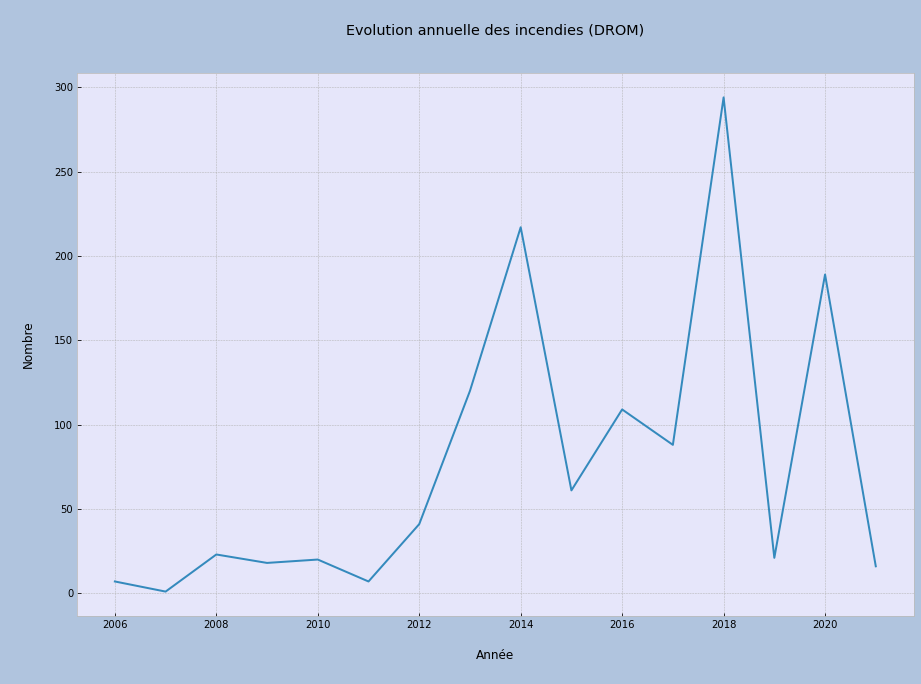

In [148]:
# visualisation du nombre d'incendie dans le temps
drom_an.compteur.plot(figsize=(15,10))

plt.title('\nEvolution annuelle des incendies (DROM)\n\n')
plt.xlabel('\nAnnée\n')
plt.ylabel('\nNombre\n')
plt.show()

La série temporelle peut être séparé en deux phases dont la limite de séparation est l'année 2011. Auparavant, la quantité d'incendie par année était très faible soit moins de 25 évènements annuels. Mais depuis 2011, leur nombre ont explosé. Dans les 3 ans qui ont suivis, les incendies ont été multipliés par 21. Les épisodes semblent suivre un cycle d'activité d'environ deux ans.  
2011 fait suite aux conséquences de la crise des subprimes de 2008-2009. De plus, l'économique des DROM repose pour la majorité sur un modèle de croissance colonial, autrement dit, les activités dépendent presque exclusivement de la consommation. Ces troubles socio-économiques post-subprimes et la hausse importante et rapide des incendies laissent supposer une origine humaine.

In [149]:
moy_a2011 = drom_an[drom_an.index <= 2011].compteur.mean()
moy_p2011 = drom_an[drom_an.index > 2011].compteur.mean()
print("\nMoyenne d'incendie dans les DROM:")
print('- antérieur à 2011:', round(moy_a2011,2))
print('- postérieur à 2011:', moy_p2011)


Moyenne d'incendie dans les DROM:
- antérieur à 2011: 12.67
- postérieur à 2011: 115.6


In [150]:
augm = (moy_p2011/moy_a2011) * 100 - 100
print('\nDepuis 2011, les DROM ont subit une augmentation de', round(augm,2),"% d'évènements incendiaires.")


Depuis 2011, les DROM ont subit une augmentation de 812.63 % d'évènements incendiaires.


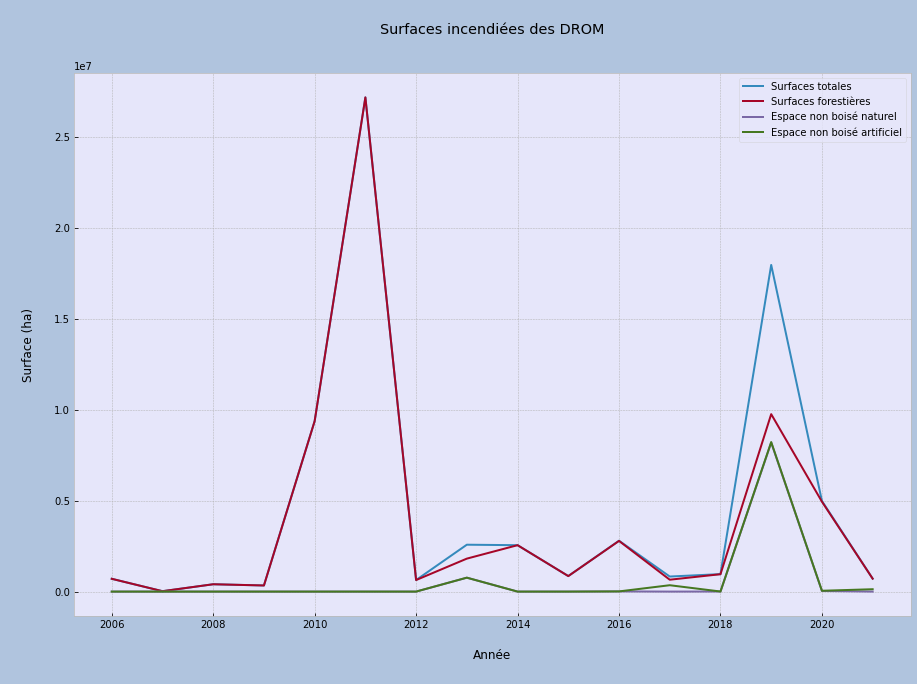

In [151]:
# visualisation des surfaces brûlées de DROM
drom_an.iloc[:,3:].plot(figsize=(15,10))

plt.title('\nSurfaces incendiées des DROM\n\n')
plt.legend(['Surfaces totales','Surfaces forestières','Espace non boisé naturel','Espace non boisé artificiel'])
plt.xlabel('\nAnnée\n')
plt.ylabel('\nSurface (ha)\n')
plt.show()

Deux épisodes notables: 2011 et 2019 dont la dernière concerne, de façon inhabituellement élevée, tous les types de surfaces. Une première sur ces 16 dernières années.  
Les pics de croissance ne sont pas cohérents avec le cycle des activités incendières nombre d'incendie mais restent bas => Les DROM subissent une activité accrue d'incendie mais leur gravité reste faible => L'efficience logistique ou les conditions environnementales ne sont pas des terraines favorables à l'expansion d'un incendie => L'étendue démesurée des surfaces brûlées lors des épisodes de 2011 et 2019 crédite l'hypothèse d'une origine criminelle.

##### [**2.2 Description temporelle**](#table-des-matières)  
  
Nous observons l'évolution de certains paramètres durant les 16 dernières années. Nous nous concentrons uniquement sur les données directement en rapport avec les incendies.

In [152]:
bdd.head(1)

,code_insee,annee,compteur,id_inc,dep,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
0,01148,2006,1,2,01,2006-02-27 13:56:00,1.0,1.0,0.0,0.0,0.0,6.2,51.0,0.0,0.0,0.0


In [153]:
# re-assemblage
stats_mois = bdd.resample('M', on='date').sum()

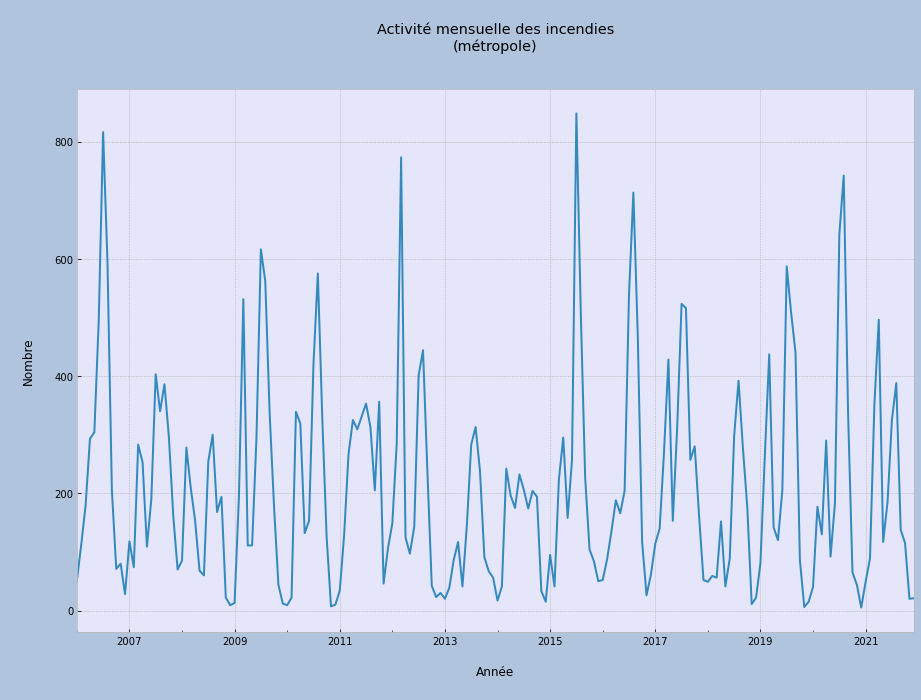

In [154]:
# visualisation du nombre d'incendie dans le temps
stats_mois.compteur.plot(figsize=(15,10))

plt.title('\nActivité mensuelle des incendies\n(métropole)\n\n')
plt.xlabel('\nAnnée\n')
plt.ylabel('\nNombre\n')
plt.show()

**Observations:**  
Saisonnalité très marqué avec une tendance d'apparence sinusoïdale.  
Pic d'activité de 2019 2,5 fois plus importante que la normale.  
Le rythme des incendies semble être cyclique. Nous passons à une visualisation annuelle des données.

In [155]:
# nombre d'incendie par année + total
stats_an = bdd.groupby(bdd.annee).sum()
print("\nNombre total d'incendie ces 16 dernières années:", stats_an.compteur.sum(), end = '.')


Nombre total d'incendie ces 16 dernières années: 40317.

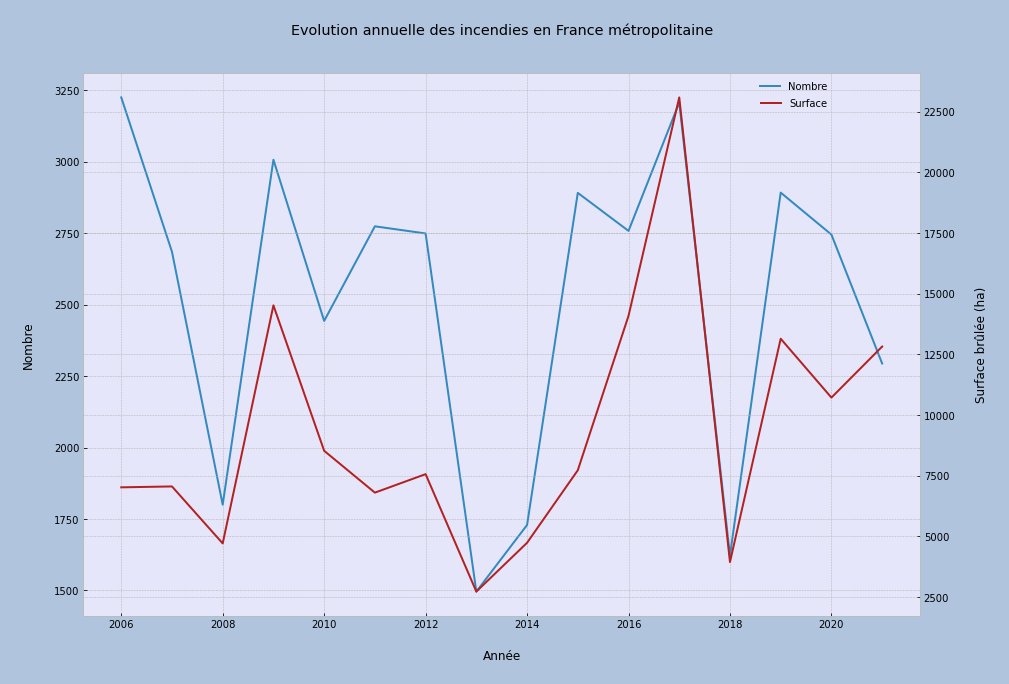

In [156]:
# nombre + taille des incendies par an
fig,ax1 = plt.subplots(figsize=(15,10))

stats_an.compteur.plot(ax=ax1, label='Nombre')
ax1.set_ylabel("\nNombre\n")
ax1.legend(bbox_to_anchor=(0.9,1), frameon=False)

ax2 = ax1.twinx()
stats_an.surf_brulee.plot(ax=ax2, color='firebrick', label='Surface')
ax2.set_ylabel('\nSurface brûlée (ha)\n')
ax2.legend(bbox_to_anchor=(0.9,0.97), frameon=False)

ax1.set_title('\nEvolution annuelle des incendies en France métropolitaine\n\n')
ax1.set_xlabel('\nAnnée\n')
plt.show()

**Nombre d'incendie:**  
Durant les 16 dernières années, plus de 40 000 incendies ont été déclarés en France.  
L'évolution du nombre annuel des incendies présente bien un caractère cyclique très marqué avec un différentiel entre les valeurs minimales et maximales d'environ 60%. Chaque cycle, durant environ 5 ans, est composé de deux pics d'activité.  
En considérant la logique de la série, 2021 est le creux "intercyclique" et 2022, la deuxième période d'intense activité du dernier cycle.  
  
**Surfaces brûlées:**  
Les surfaces brûlées suivent la même cadence que les effectifs mais n'observent pas les mêmes variations. En 2006, 2011 et 2019, malgré un nombre colossal d'évènements, les surfaces atteintes sont restées restreintes. Deux facteurs entrent en jeu dans ce genre épisode. Soit la réactivité humaine a été efficente, soient les conditions environnementales n'ont pas été propices.  
Notons que les pics d'activité d'un cycle présentent deux profils très distincts caractérisés par la rapport entre le nombre de feux et la quatité d'hectares brûlé.

In [157]:
# préparation du df départemental
bdd_dep = bdd.groupby(['dep','annee']).sum()
bdd_dep.reset_index(inplace=True)
bdd_dep.head(1)

,dep,annee,compteur,id_inc,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
0,01,2006,12,140,27.0,27.0,0.0,0.0,0.0,48.4,508.0,0.0,0.0,3100.0


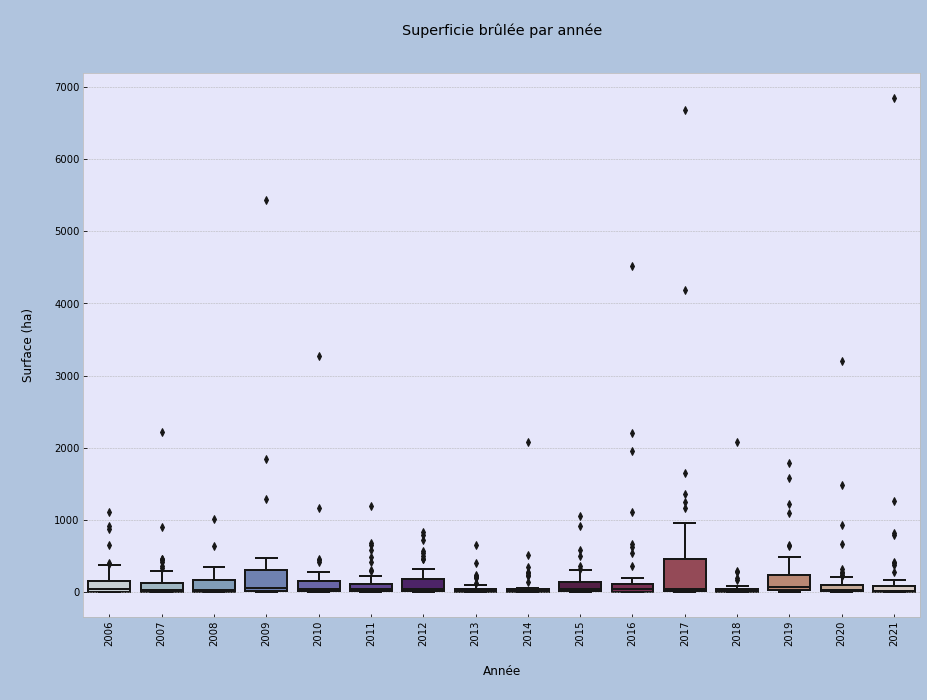

In [158]:
# boxplot des surfaces brûlées par année
plt.figure(figsize = (15, 10))

ax = sns.boxplot(x = 'annee', y = 'surf_brulee', data = bdd_dep, palette = "twilight")

plt.xlabel('\nAnnée\n')
plt.ylabel('\nSurface (ha)\n')
plt.xticks(rotation = 90)
plt.title('\nSuperficie brûlée par année\n\n')
plt.show()

Nous retrouvons ici les variations des surfaces incendiées au cours du temps. Nous pouvons retracer les cycles d'activité incendiaires précédemment mis en valeur dans la série temporelle mais avec une mise en évidence des outliers. 2017 consitue l'année la plus intense en terme d'activité et de superficie. Les évènements exceptionnels sont également très importants même pour les autres années de son cycle.

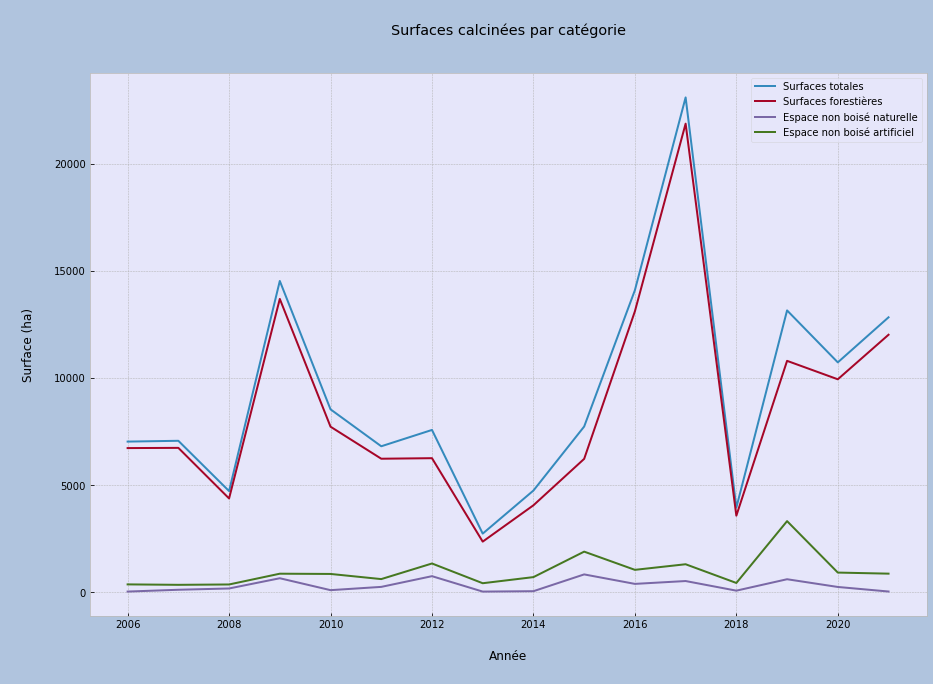

In [159]:
# visualisation des surfaces brûlées annuelles
stats_an.iloc[:,2:6].plot(figsize=(15,10))

plt.title('\nSurfaces calcinées par catégorie\n\n')
plt.xlabel('\nAnnée\n')
plt.ylabel('\nSurface (ha)\n')
plt.legend(["Surfaces totales","Surfaces forestières","Espace non boisé naturelle","Espace non boisé artificiel"])
plt.show()

**Observations générales:**  
~ Les données des surfaces brûlées suivent logiquement le nombre des incendies: le caractère cyclique est conservée;  
~ Les espaces boisées naturelles sont les principales types de surfaces brûlées par les incendies;  
~ On observe des pics d'activité réguliers chez les deux autres catégories de surfaces. Ces maximales semblent régulièrement de produire tous les deux ans environ. A vue d'oeil, ils sont en parfaite adéquation avec chaque pic d'activité des incendies. 
  
**Cas particuliers:**  
~ Une anomalie se remarque en début de série. Malgré une nombre d'incendie comparable au maximum de 2017, le nombre d'hectares est 3 fois moins importantes.  
Deux explications possibles:  
-> maîtrise rapide des feux empêchant leur propagation;  
-> les conditions environnementales ne leur ont pas été opportunes;  

~ En 2019, toutes les surfaces brûlées subissent une hausse au moins deux fois plus importante que la normale pour un "pic d'activité cyclique";  
~ Nous retrouvons une caractéristique importante des espaces non boisés, à savoir le taux d'embrasement le plus bas.

In [160]:
# culture G de passage: la superfie de la France métropolitaine (ha) en ha
surf_fr = 551695 * 100

In [161]:
# surfaces brûlées en 16 ans
surf_tot = bdd.surf_brulee.sum()
surf_tot_p = surf_tot * 100 / surf_fr
print("\nEn 16 ans, l'équivalent de", round(surf_tot_p, 2), "% du territoire métropolitain a été brûlé par les incendies.")


En 16 ans, l'équivalent de 0.27 % du territoire métropolitain a été brûlé par les incendies.


In [162]:
# représentation des surfaces brûlées
surf_nat = stats_an.surf_nB_nat.sum() * 100 / stats_an.surf_brulee.sum()
surf_artf = stats_an.surf_nB_artf.sum() * 100 / stats_an.surf_brulee.sum()

print("\nDurant les 16 dernières années:")
print("Espaces non boisées naturelles =", round(surf_nat,2), "% des terres brûlées.")
print("Surfaces non boisées artificielles =", round(surf_artf,2), '% des terres brûlées.')


Durant les 16 dernières années:
Espaces non boisées naturelles = 3.09 % des terres brûlées.
Surfaces non boisées artificielles = 10.33 % des terres brûlées.


Les domaines artificielles présentent un risque trois fois plus élevé de s'enflammer que les surfaces naturelles => l'activité botanique humaine est un facteur de développement incendiaire.

In [163]:
# regroupement des données par mois
saison = bdd.groupby(bdd.date.dt.month).sum()

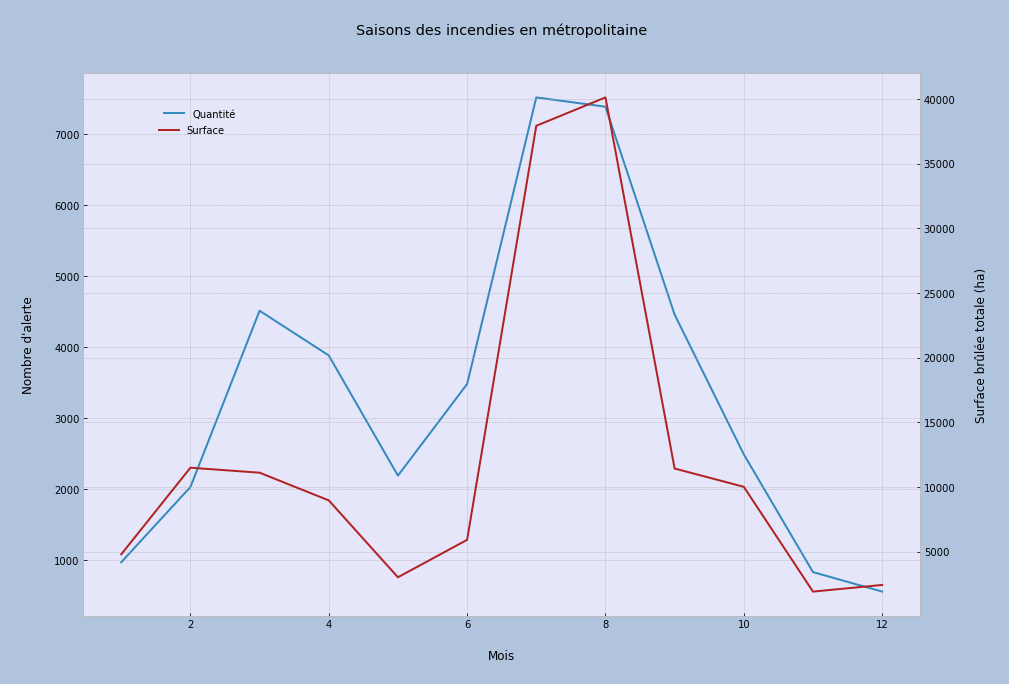

In [164]:
# visualisation du nombre d'incendie rapporté à un an
fig, ax = plt.subplots(figsize=(15,10))

saison.compteur.plot(label="Quantité")
ax.set_ylabel("\nNombre d'alerte\n")
ax.legend(bbox_to_anchor=(0.193,.95), frameon=False)

ax_ = ax.twinx()
saison.surf_brulee.plot(color='firebrick', label="Surface")
ax_.set_ylabel('\nSurface brûlée totale (ha)\n')
ax_.legend(bbox_to_anchor=(0.18,0.92), frameon=False)

ax.set_title('\nSaisons des incendies en métropolitaine\n\n')
ax.set_xlabel('\nMois\n')
plt.show()

**Observations:**  
- Il existe deux saisons distinctes: printemps et en été/automne;  
- Présence de brasiers même en hivers;  
- Saison printemps: dure environ 3 mois, aires calcinées de faible superficie, déclin coïncidant avec le cycle écologique de la végétation;  
- Saison été: deux fois plus grande en nombre et durée, ravages 4 fois plus importants, regain des embrasements en terme de taille (phéno. d'incendie zombie?), coïncide avec l'activité estivale de la société, le mois d'octobre est généralement synonyme de baisse de température;  
=> L'été est la saison la plus à risque avec un prolongement important en automne.

o Les cycles

In [165]:
# détermination des dates inter-cycles = minimals
interCycl = stats_an[stats_an.compteur < 2000]
interCycl1, interCycl2, fxinterCycl, interCycl3 = interCycl.index

In [166]:
# regroupement des données par cycle
cycl1 = bdd[(bdd.date.dt.year >= interCycl1) & (bdd.date.dt.year < interCycl2)]
cycl2 = bdd[(bdd.date.dt.year >= interCycl2) & (bdd.date.dt.year > interCycl3)]

In [167]:
# calcul des surfaces brûlées par cycle (ha) + % territoire
surf_cycl1 = cycl1.surf_brulee.sum()
surf_cycl1_p = surf_cycl1 * 100 / surf_fr
surf_cycl2 = cycl2.surf_brulee.sum()
surf_cycl2_p = surf_cycl2 * 100 / surf_fr

In [168]:
print("\nCycle 1 =", round(surf_cycl1_p,2), "% du territoire national.")
print("Cycle 2 =", round(surf_cycl2_p,2), "% du territoire national.")


Cycle 1 = 0.08 % du territoire national.
Cycle 2 = 0.07 % du territoire national.


Tous les 5 ans, en moyenne 0.08% de la France métropolitaine est carbonisé.

In [169]:
# nombre d'incendie inférieur à 1 000 ha
len(bdd[bdd.surf_brulee<=1000])

40298

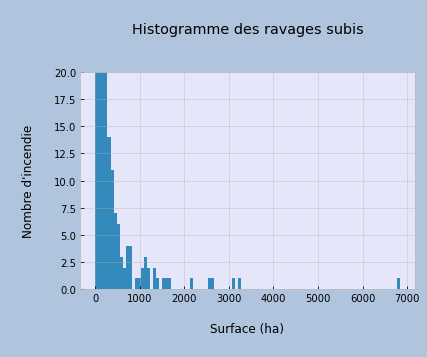

In [170]:
# histogramme des surfces brûlées
plt.hist( bdd.surf_brulee, bins=100)

plt.title("\nHistogramme des ravages subis\n\n")
plt.xlabel('\nSurface (ha)\n')
plt.ylabel("\nNombre d'incendie\n")
plt.ylim(0, 20)
plt.show()

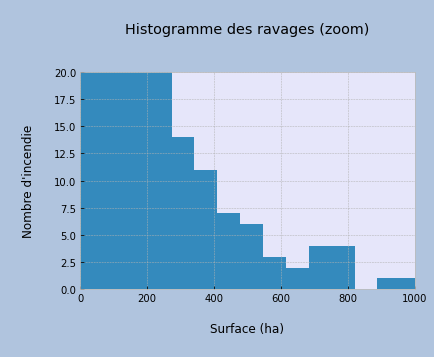

In [171]:
# histogramme des surfaces brûlées
plt.hist( bdd.surf_brulee, bins=100)

plt.title("\nHistogramme des ravages (zoom)\n\n")
plt.xlabel('\nSurface (ha)\n')
plt.ylabel("\nNombre d'incendie\n")
plt.xlim(0,1000)
plt.ylim(0,20)
plt.show()

**Observations:**  
- 40 000 feux a une surface inférieure à 800 ha soient plus de 99% des incendies;  
- Les effectifs décroissent de façon logarithmique avec la taille;
- Les incendies de plus de 1000 ha restent des évènements exceptionnels et isolés.

##### [**2.3 Description spatiale**](#table-des-matières)

In [172]:
# liste des années observées
list_annee = [2006, 2011, 2016, 2021]

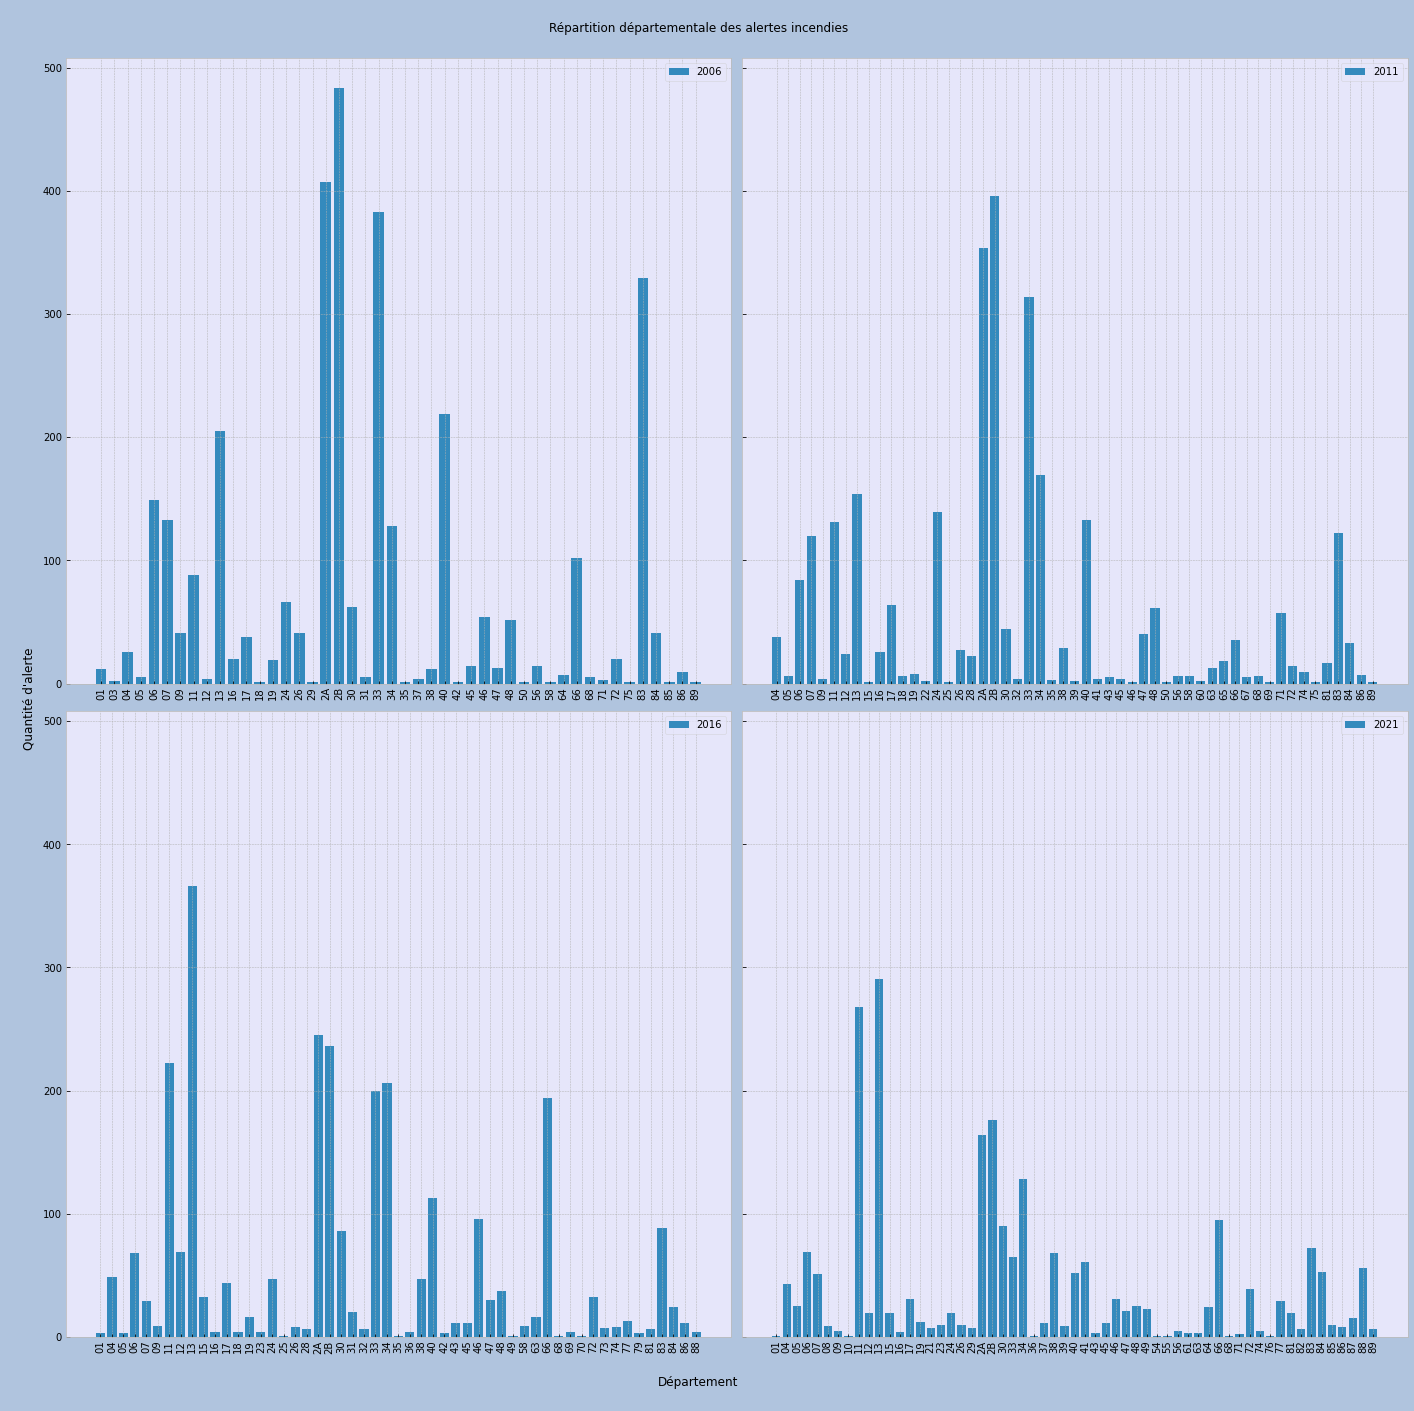

In [173]:
# répartition des incendies par département pour certaine année
fig,ax = plt.subplots(2,2, sharey=True, tight_layout=True, figsize=(20,20))

ax[0,0].bar(bdd_dep[bdd_dep.annee==list_annee[0]].dep,bdd_dep[bdd_dep.annee==list_annee[0]].compteur, label=list_annee[0])
ax[0,1].bar(bdd_dep[bdd_dep.annee==list_annee[1]].dep,bdd_dep[bdd_dep.annee==list_annee[1]].compteur, label=list_annee[1])
ax[1,0].bar(bdd_dep[bdd_dep.annee==list_annee[2]].dep,bdd_dep[bdd_dep.annee==list_annee[2]].compteur, label=list_annee[2])
ax[1,1].bar(bdd_dep[bdd_dep.annee==list_annee[3]].dep,bdd_dep[bdd_dep.annee==list_annee[3]].compteur, label=list_annee[3])

ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,1].tick_params(axis='x', labelrotation=90)

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

fig.suptitle("\nRépartition départementale des alertes incendies\n\n")
fig.supxlabel('\nDépartement\n')
fig.supylabel("\nQuantité d'alerte\n")
plt.show()

Parmi les départemens les plus à risque en terme d'effectif, nous avons l'Aude (11), les Bouches-du-Rhône (13), la Corse (2A-B), la Gironde (33), l'Hérault (34), les Pyrénées-Orientales (66) et le Var (83).  
Dû à la politique de prévention des incendies, la fréquence des combustions tend à diminuer avec les années mais leurs présences s'étendent à plus de départements.  
Nous quantifions cette observation à l'aide de la courbe de Lorenz et de l'indice de Gini.

In [174]:
# indices de concentration Lorenz+Gini pour 2006
vol_2006 = bdd_dep[bdd_dep.annee==2006].compteur.values
n_2006 = len(vol_2006)

lorenz_2006 = np.cumsum(np.sort(vol_2006)) / vol_2006.sum()
lorenz_2006 = np.append([0], lorenz_2006)

auc = (lorenz_2006.sum() - lorenz_2006[-1]/2 - lorenz_2006[0]/2) / n_2006
s = 0.5 - auc
gini_2006 = 2 * s

In [175]:
# indices de concentration Lorenz+Gini pour 2021
vol_2021 = bdd_dep[bdd_dep.annee==2021].compteur.values
n_2021 = len(vol_2021)

lorenz_2021 = np.cumsum(np.sort(vol_2021)) / vol_2021.sum()
lorenz_2021 = np.append([0], lorenz_2021)

auc = (lorenz_2021.sum() - lorenz_2021[-1]/2 - lorenz_2021[0]/2) / n_2021
s = 0.5 - auc
gini_2021 = 2 * s

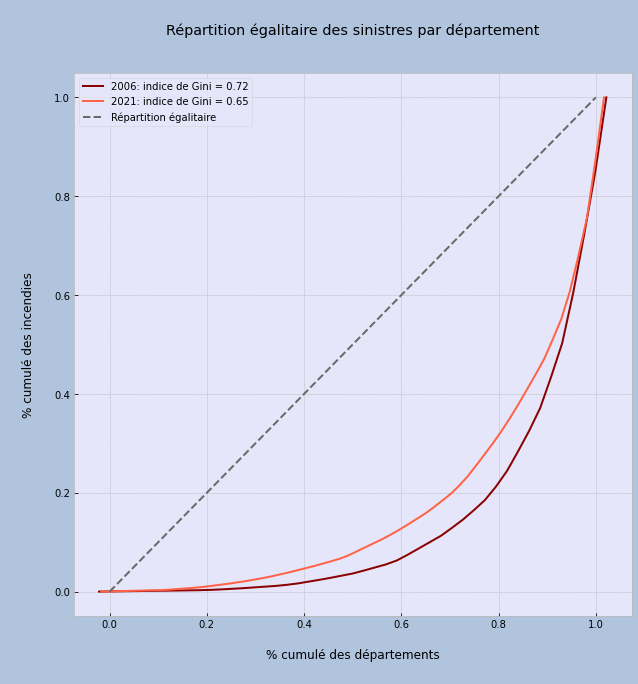

In [176]:
# courbe de Lorenz et indice de Gini pour 2006 et 2021
fig,ax = plt.subplots(figsize=(10,10))

xaxis_2006 = np.linspace(0 - 1/n_2006, 1 + 1/n_2006, n_2006 + 1)
ax.plot(xaxis_2006, lorenz_2006, color='darkred', label='2006: indice de Gini = {}'.format(round(gini_2006,2)))

xaxis_2021 = np.linspace(0 - 1/n_2021, 1 + 1/n_2021, n_2021 + 1)
ax.plot(xaxis_2021, lorenz_2021, color='tomato', label='2021: indice de Gini = {}'.format(round(gini_2021,2)))

ax.plot([0, 1], [0, 1], color='dimgray', linestyle='--', label='Répartition égalitaire')
ax.legend()
ax.set_title("\nRépartition égalitaire des sinistres par département\n\n")
ax.set_xlabel('\n% cumulé des départements\n')
ax.set_ylabel('\n% cumulé des incendies\n')
plt.show()

La courbe de Lorenz tend davantage vers la répartition égalitaire et en 15 ans, l'indice de Gini a perdu 11 points.  
Ainsi, la représentation graphique de la courbe de Lorenz et le calcul de l'indice de Gini valident les observations faites précédemment sur l'augmentation du nombre de départements embrasés.

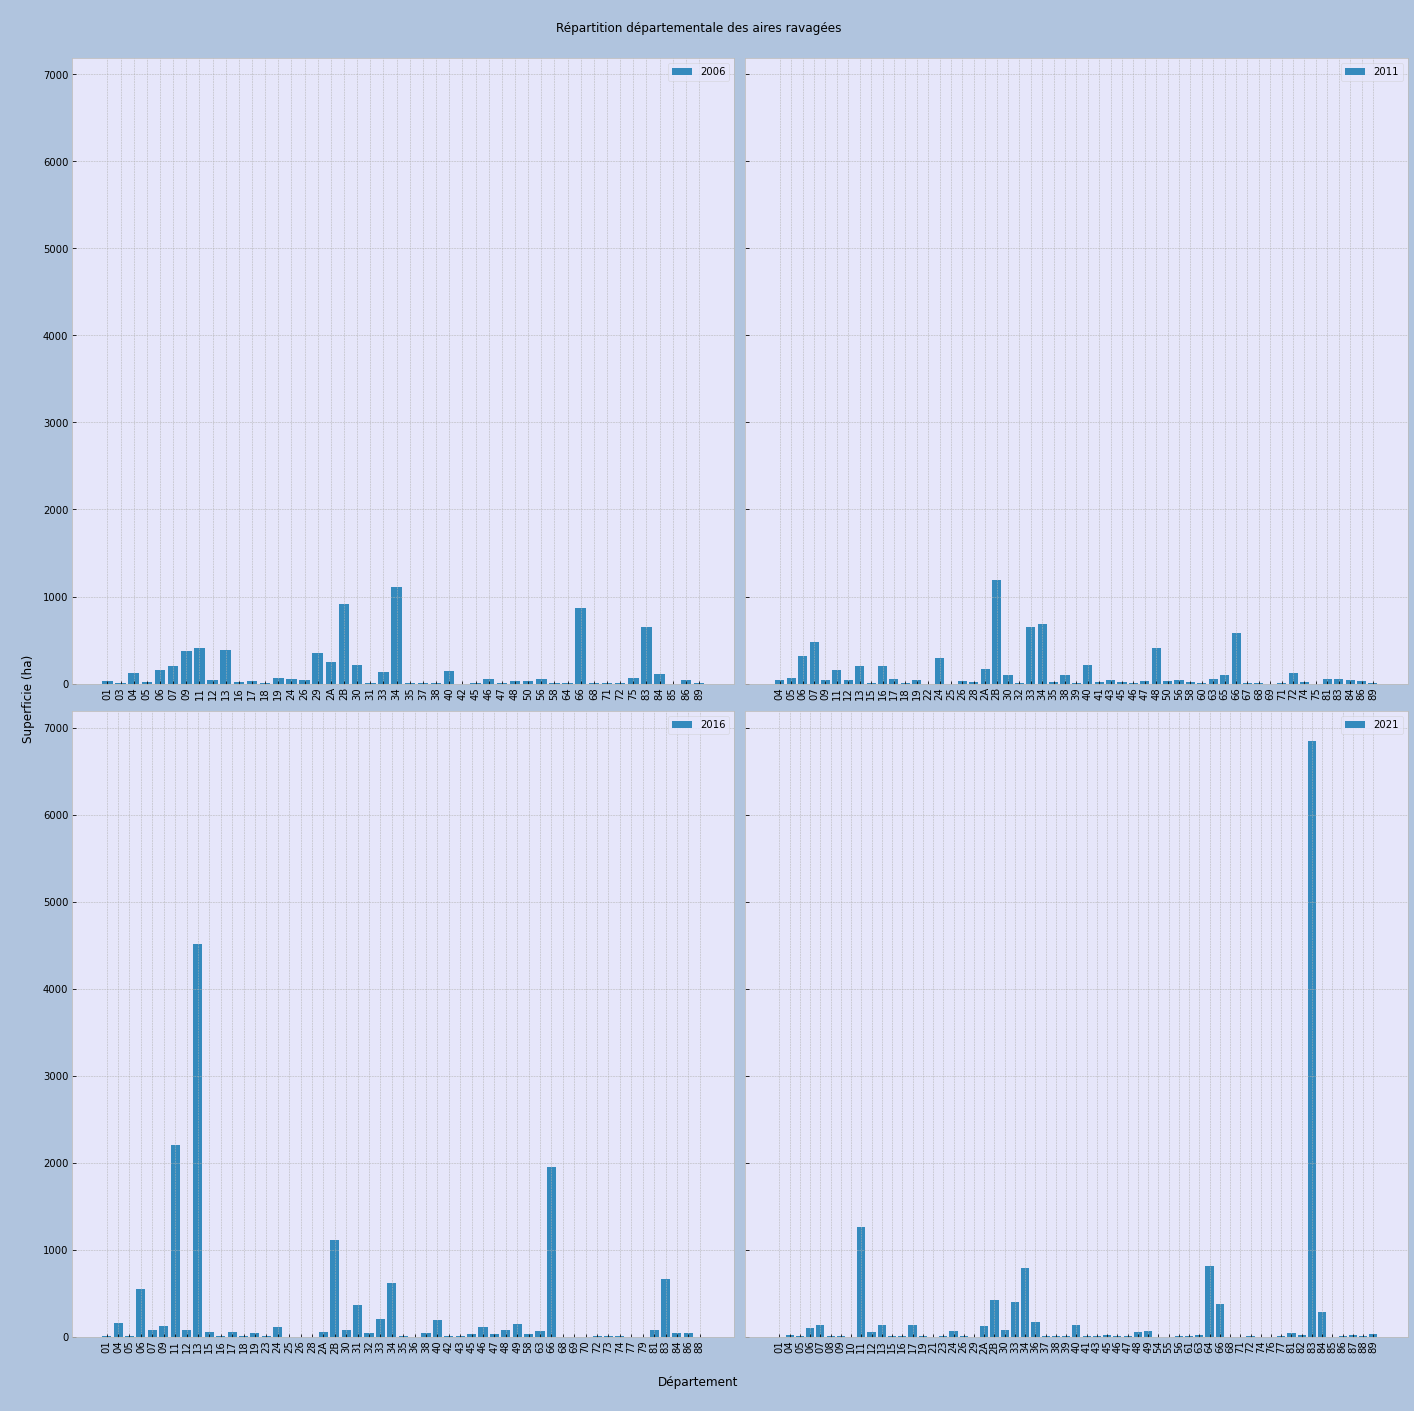

In [177]:
# répartition des incendies par surface et par département
fig,ax = plt.subplots(2,2, sharey=True, tight_layout=True, figsize=(20,20))

ax[0,0].bar(bdd_dep[bdd_dep.annee==list_annee[0]].dep,bdd_dep[bdd_dep.annee==list_annee[0]].surf_brulee, label=list_annee[0])
ax[0,1].bar(bdd_dep[bdd_dep.annee==list_annee[1]].dep,bdd_dep[bdd_dep.annee==list_annee[1]].surf_brulee, label=list_annee[1])
ax[1,0].bar(bdd_dep[bdd_dep.annee==list_annee[2]].dep,bdd_dep[bdd_dep.annee==list_annee[2]].surf_brulee, label=list_annee[2])
ax[1,1].bar(bdd_dep[bdd_dep.annee==list_annee[3]].dep,bdd_dep[bdd_dep.annee==list_annee[3]].surf_brulee, label=list_annee[3])

ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,1].tick_params(axis='x', labelrotation=90)

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

fig.suptitle("\nRépartition départementale des aires ravagées\n\n")
fig.supxlabel('\nDépartement\n')
fig.supylabel("\nSuperficie (ha)\n")
plt.show()

Rappelons qu'un brasier de plus de 100 ha est qualifié de "Grand Feu".  
Ces graphiques mettent en évidence la présence de huit outliers représentant des incendies de plus de 1000 ha. Il s'agit d'évènements très exceptionnels dont la fréquence et l'intensité ont augmenté au cours des 16 dernières années. Ces GF exceptionnels ont lieu dans les départements les plus à risque. Pour les plus importants sont concernés l'Aude, les Bouches-du-Rhône, le Var et les Pyrénées-Orietales.  
Penchons-nous sur les incendies "habituels".

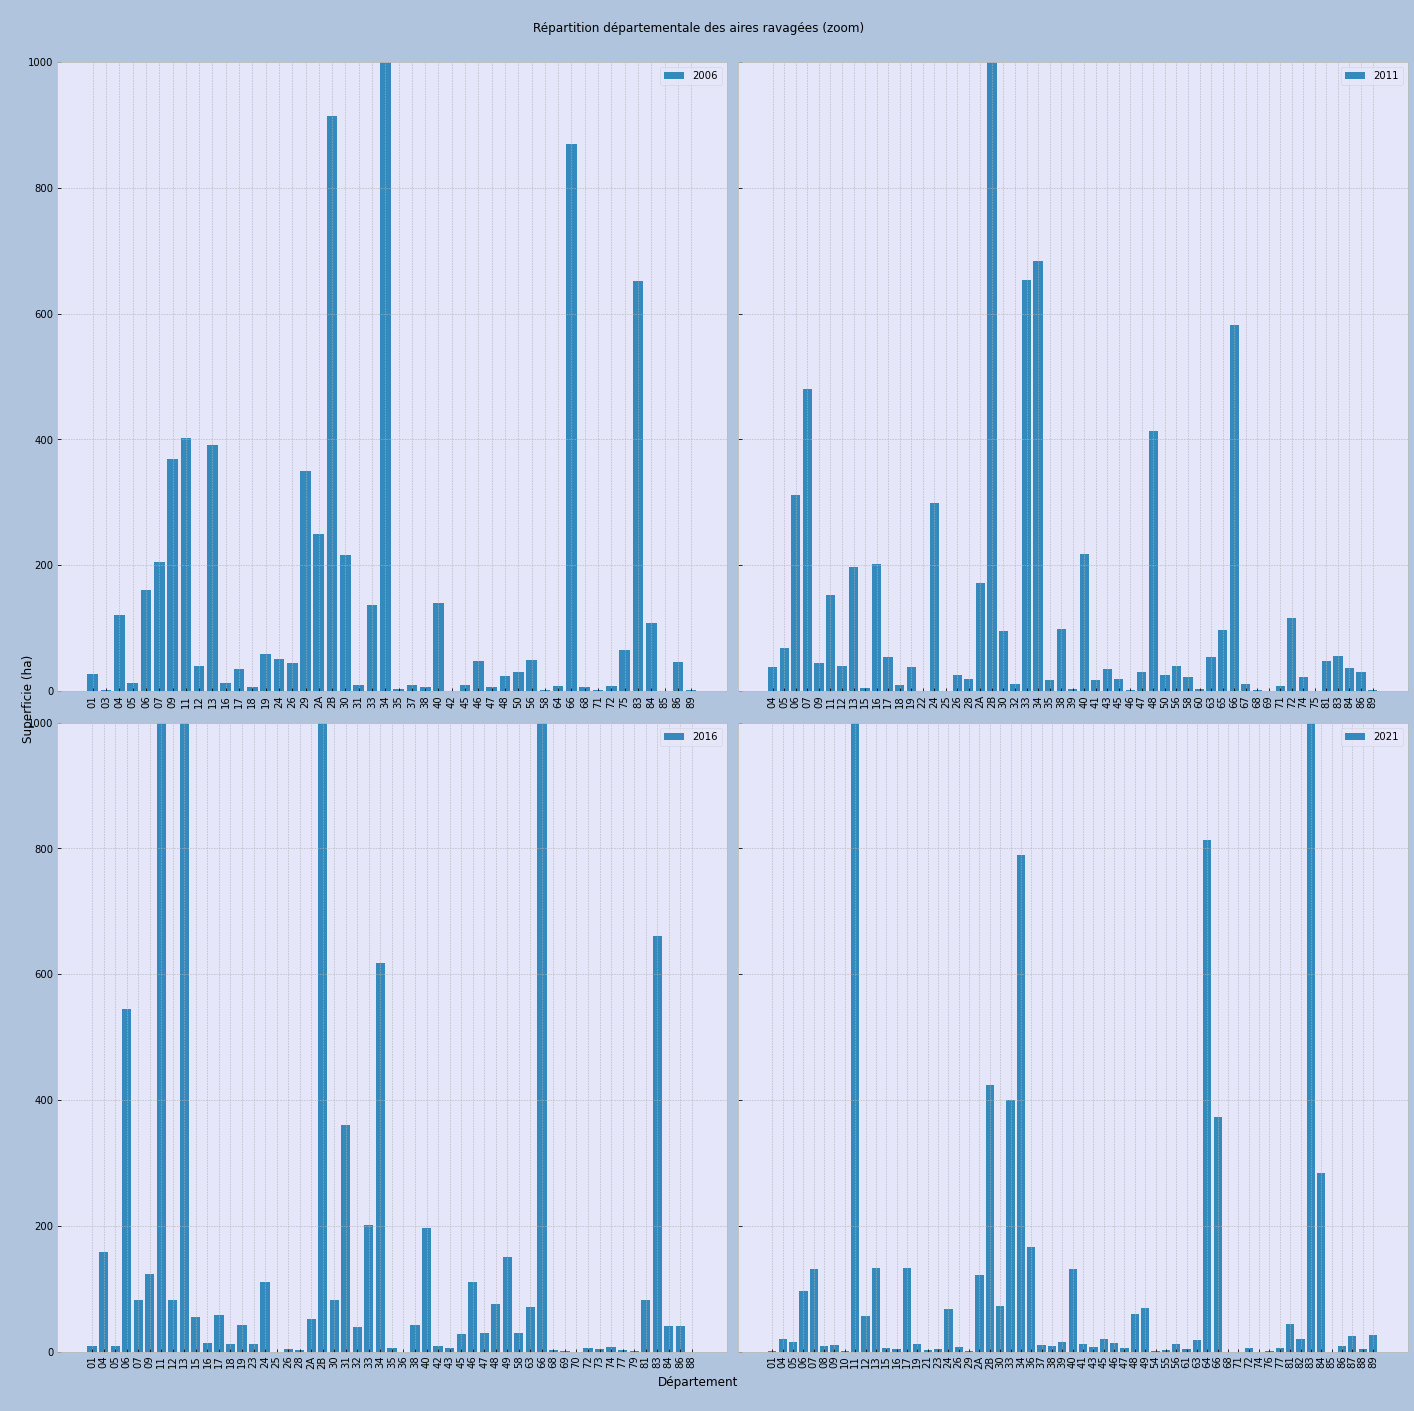

In [178]:
# répartition des incendies par surface et par département [zoom]
fig,ax = plt.subplots(2,2, sharey=True, tight_layout=True, figsize=(20,20))

ax[0,0].bar(bdd_dep[bdd_dep.annee==list_annee[0]].dep,bdd_dep[bdd_dep.annee==list_annee[0]].surf_brulee, label=list_annee[0])
ax[0,1].bar(bdd_dep[bdd_dep.annee==list_annee[1]].dep,bdd_dep[bdd_dep.annee==list_annee[1]].surf_brulee, label=list_annee[1])
ax[1,0].bar(bdd_dep[bdd_dep.annee==list_annee[2]].dep,bdd_dep[bdd_dep.annee==list_annee[2]].surf_brulee, label=list_annee[2])
ax[1,1].bar(bdd_dep[bdd_dep.annee==list_annee[3]].dep,bdd_dep[bdd_dep.annee==list_annee[3]].surf_brulee, label=list_annee[3])

ax[0,0].tick_params(axis='x', labelrotation=90)
ax[0,1].tick_params(axis='x', labelrotation=90)
ax[1,0].tick_params(axis='x', labelrotation=90)
ax[1,1].tick_params(axis='x', labelrotation=90)

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()
ax[1,1].legend()

ax[0,0].set_ylim(0,1000)
ax[0,1].set_ylim(0,1000)
ax[1,0].set_ylim(0,1000)
ax[1,1].set_ylim(0,1000)

fig.suptitle("\nRépartition départementale des aires ravagées (zoom)\n\n")
fig.supxlabel('Département\n')
fig.supylabel("\nSuperficie (ha)")
plt.show()

Durant les dernières décénnies, la fréquence des combustions a augmenté en même temps que leurs superficies ont diminué. En prenant en compte l'évolution des conditions climatiques plus favorables aux incendies et les autres paramètres environnementaux considérés constants durant cette période, on peut déduire de cette diminution une amélioration dans la qualité des interventions.  
  
Comme la présence de outliers ne nous permet pas d'avoir une bonne appréciation sur la répartition des surfaces incendiées par département, nous procédons à une représentation en boxplot des espaces par année.

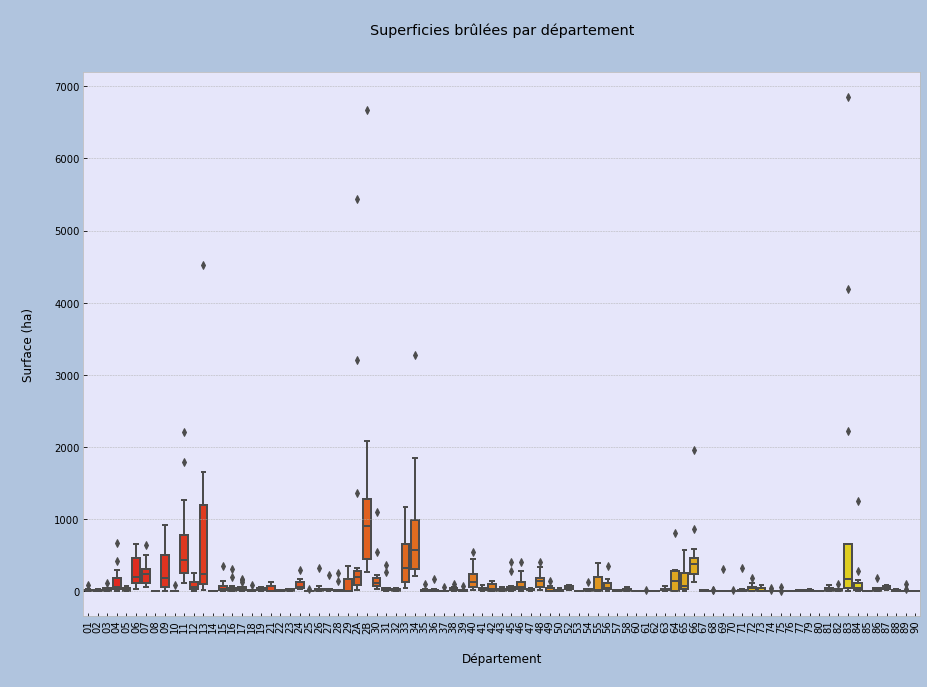

In [179]:
# boxplot des surfaces brûlées par département
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x='dep', y='surf_brulee', data=bdd_dep, palette="autumn")

plt.xlabel('\nDépartement\n')
plt.ylabel('\nSurface (ha)\n')
plt.xticks(rotation=90)
plt.title('\nSuperficies brûlées par département\n\n')
plt.show()

Les départements peuvent être répartis en trois groupes.  
  
Le premier dont la variation des surfaces brûlées est au minimum égales à 1 000 ha. Nous y retrouvons l'Aude (11), Les Bouhes-du-Rhône (13), la Haute-Corse (2B), la Gironde (33) et l'Hérault (34). Nous y incluons également l'Ariège (09) dont les superficies atteintes sont très proches de 1 000 ha et ne présentent pas de outliers.  
  
Dans la deuxième partie sont rassemblés les départements dont les fluctuations des surfaces incendiées sont de l'ordre de plusieurs centaines d'hectares. C'est le cas par exemple, du Var (83) ou des Landes (40).  
  
Enfin, la dernière catégorie réunit les départements dont les aires des incendies varient de quelques dizaines d'hectares. Il s'agit de profil du type des Hautes-Alpes (05) ou encore du Tarn (81).

A partir de maintenant, nous considérons la qualité des interventions humaines comme étant constante d'un incendie à un autre. Nous avons vu que le nombre et les superficies brûlées par les incendies apparaîssaient pas ou peu corrélés. Nous savons que l'étendue d'un incendie résulte de plusieurs facteurs. Dans le prochain chapitre, nous étudions l'influence des paramètres écologiques sur la tailles des feux.

#### [**3. Structures des données**](#table-des-matières)  
  
Nous commençons par étudier les corrélations entre certaines variables. Ensuite, nous réalisons un clustering des incendies et pour finir, nous étudions les caractéristiques des classes résultantes.
  
##### [**3.1 Variables: étude de corrélations**](#table-des-matières)  
  
##### [**3.1.1 Les données météorologiques**](#table-des-matières)  
  
Nous étudions les relations entre les autres paramètres météo. Tous sont des variables qualitatives donc nous employons le test du Chi² pour mesurer leurs degrés de corrélation.

In [180]:
# sont concernées les 6 dernières colonnes
bdd.head(1)

,code_insee,annee,compteur,id_inc,dep,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
0,01148,2006,1,2,01,2006-02-27 13:56:00,1.0,1.0,0.0,0.0,0.0,6.2,51.0,0.0,0.0,0.0


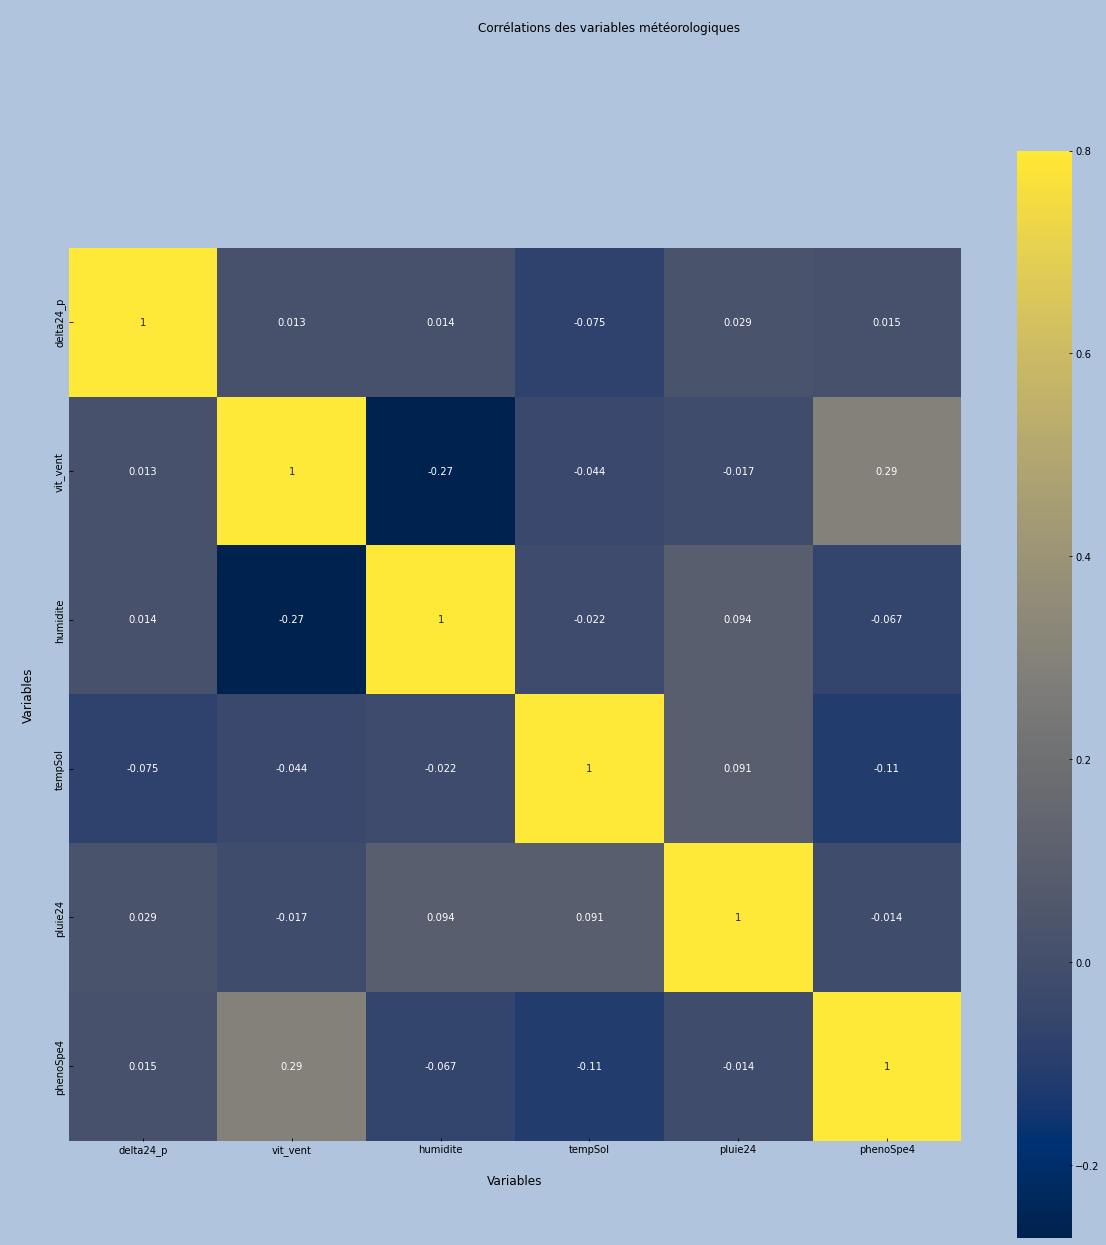

In [181]:
# heatmap des corrélations entre les paramètres météo (6 dernières colonnes)
mat_corr = bdd.iloc[:,-6:].corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(mat_corr, vmax=.8, square=True, annot=True, cmap="cividis")

fig.suptitle('\nCorrélations des variables météorologiques')
ax.set_xlabel('\nVariables')
ax.set_ylabel('\nVariables\n')
plt.show()

Les couples (vitesse du vent-taux d'humidité) et (vitesse du vent-phénomène spéciaux) ont le niveau de corrélation le plus fort mais nous jugeons |26|% beaucoup trop bas pour écarter une des variables.  
=> Toutes les variables météo sont conservées.

##### [**3.1.2 Surfaces brûlées et départements**](#table-des-matières)  
  
Nous savons que les plus grandes surfaces incendiées sont concentrés dans une poignée de départments. Ce test nous permet de mettre en évidence un éventuel lien entre les superficies calcinées et les départements.  
Nous avons respectivement une variable qualitative et une variable quantitative continue => analyse ANOVA.

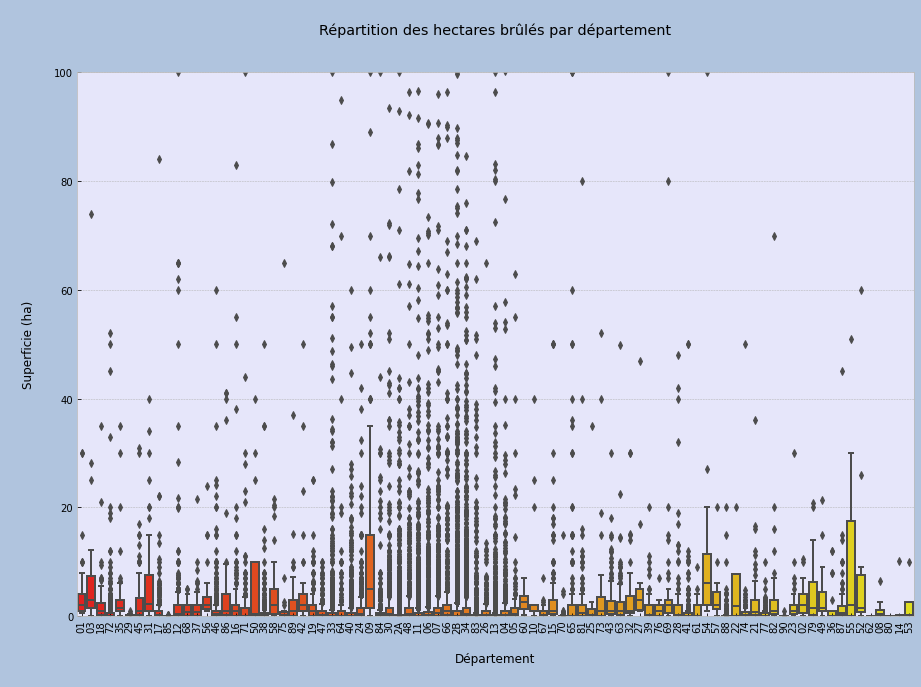

In [182]:
# représentation des revenus par pays
plt.figure(figsize=(15, 10))

ax = sns.boxplot(x='dep', y='surf_brulee', data=bdd, palette="autumn")

plt.xlabel('\nDépartement\n')
plt.ylabel('\nSuperficie (ha)\n')
plt.xticks(rotation=90)
plt.ylim(0,100)
plt.title('\nRépartition des hectares brûlés par département\n\n')
plt.show()

Les surfaces sont très dispersées pour l'ensemble des départements. Aucune relation entre les départements et les surfaces brûlées ne ressort de cette représentation. Nous quantifions cette observation en calculant le coefficient eta².

In [183]:
# calcul du rapport de corrélation entre 'age' et 'categ'
def eta_squared(x,y):
    moyenne_y = y.mean()
    classe = []
    for modalite in x.unique():
        yi_val = y[x==modalite]
        classe.append({'ni':len(yi_val),
                       'moyenne_var_qte':yi_val.mean()})
    sct = sum([(yj - moyenne_y) ** 2 for yj in y])
    sce = sum([c['ni'] * (c['moyenne_var_qte'] - moyenne_y) ** 2 for c in classe])
    return round(sce / sct, 2)
    
eta_2 = eta_squared(bdd.dep, bdd.surf_brulee)
print('\nCoefficient de corrélation eta-deux =', eta_2)


Coefficient de corrélation eta-deux = 0.0


Le coefficient de corrélation étant très proche de zéro, nous ne concluons pas à l'existence qu'il n'existe pas de lien de corrélation entre les deux variables.  
  
##### [**3.1.3 Roche et indices géologiques**](#table-des-matières)  
  
Bien que les valeurs soient numériques, toutes les variables géologiques sont qualitatives.

In [184]:
bdd_ign.head(1)

,code_insee,annee,compteur,id_inc,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,...,dep,essence,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau
0,01148,2006,1,2,2006-02-27 13:56:00,1.0,1.0,0.0,0.0,0.0,...,01,03,310.0,7,5,1,9,6,7,115.0


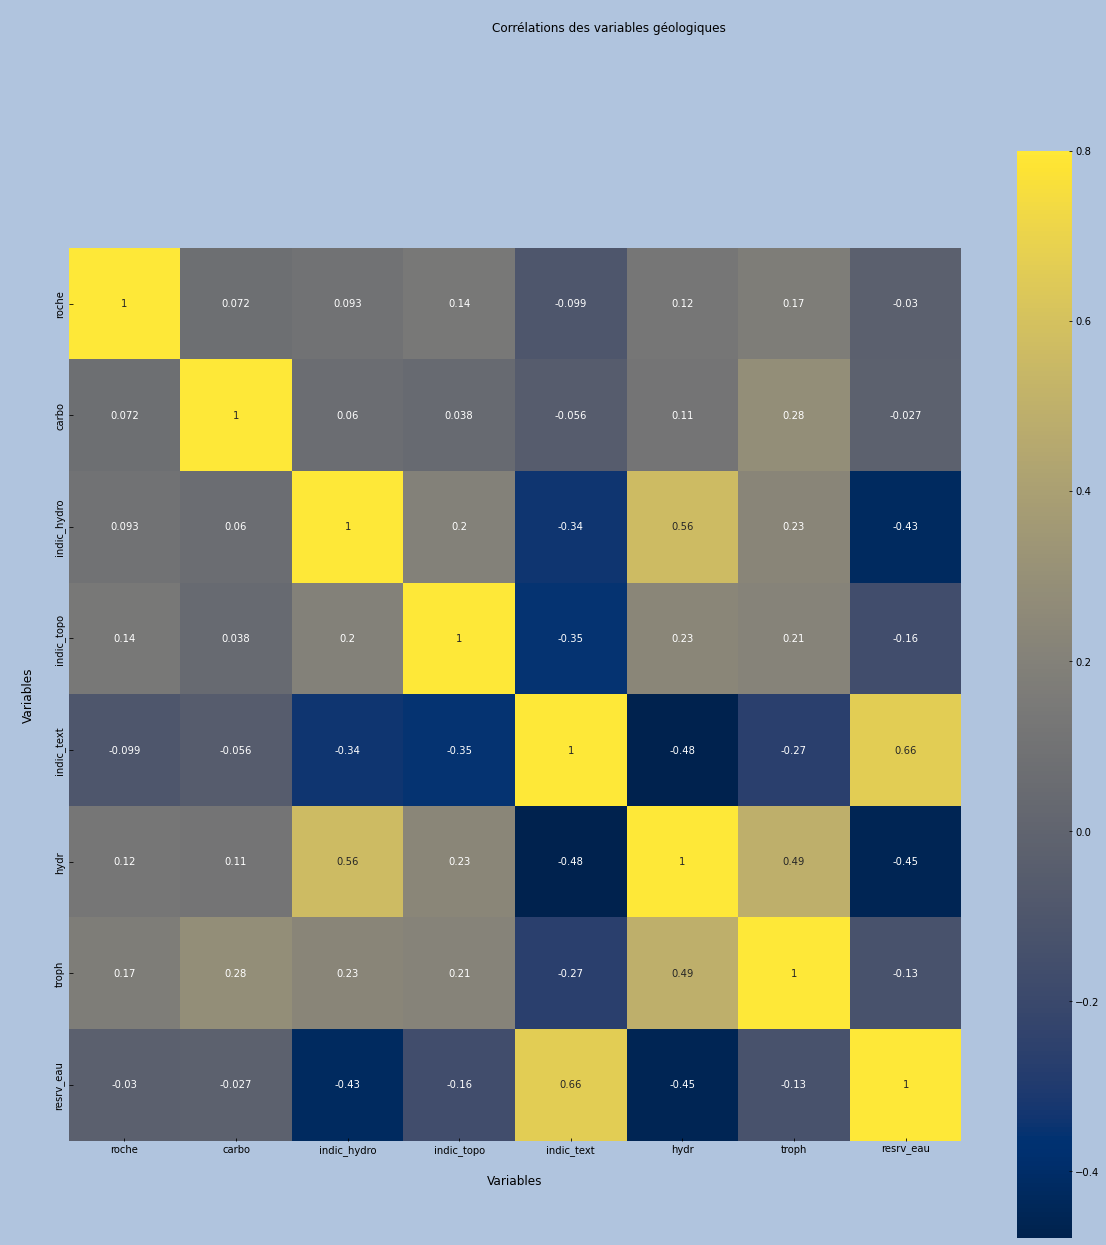

In [185]:
# heatmap des corrélations entre les paramètres géo. (8 dernières colonnes)
mat_corr = bdd_ign.iloc[:,-8:].corr()
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(mat_corr, vmax=.8, square=True, annot=True, cmap="cividis")

fig.suptitle('\nCorrélations des variables géologiques')
ax.set_xlabel('\nVariables\n')
ax.set_ylabel('\nVariables\n')
plt.show()

Les variables "réserve en eau" et "indice de texture" ont le degré de corrélation le plus élevé: 66%. Ces deux paramètres permettent de caractériser un sol sur deux aspects liés mais distincts donc nous ne jugeaons pas cette différence assez pertinente pour écarter un des indices.  
Il en va de même pour le niveau hydrique et indice d'hydromorphie qui sont supposés être exploités en parallèe selon les recommandations de l'IGN.  
Tous les niveaus de gris correspondent aux relations fortement indépendantes.

##### [**3.1.4 Surfaces brûlées et espaces forestiers**](#table-des-matières)  
  
Les premières représentations graphiques ont montré une correspondance étroite entre ces deux variables. D'un point de vue quantitatif, nous savons que les forêts constituent plus de 90% des surfaces brûlées donc le lien de corrélation entre les deux paramètres paraît évident.  
Elles sont de nature quantitative continue => nous les représentons sous forme de scatterplot et calculons le coefficient de corrélation.

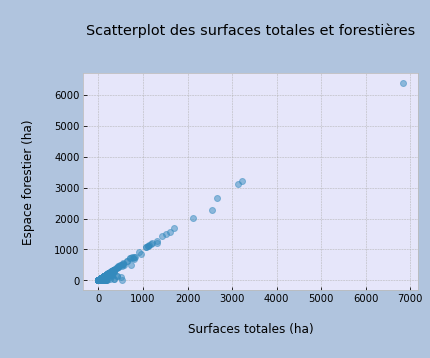

In [186]:
# scatterplot surfaces + forêt
plt.plot(bdd.surf_brulee, bdd.surf_foret, 'o', alpha = 0.5)
plt.title('\nScatterplot des surfaces totales et forestières\n\n')
plt.xlabel("\nSurfaces totales (ha)\n")
plt.ylabel("\nEspace forestier (ha)\n")
plt.show()

La relation linéaire est incontestable. La présence diffuse d'individus près de l'origine peut être dû à des outliers. Nous passons à la quantifications de ce rapport.

In [187]:
# préparation des données
x = np.array(bdd.surf_brulee)
y = np.array(bdd.surf_foret)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [188]:
# phase d'initialisation + adaptation aux données
model = LinearRegression()
model.fit(x, y)

LinearRegression()

In [189]:
# phase de prédiction de la modélisation
y_predit = model.predict(x)

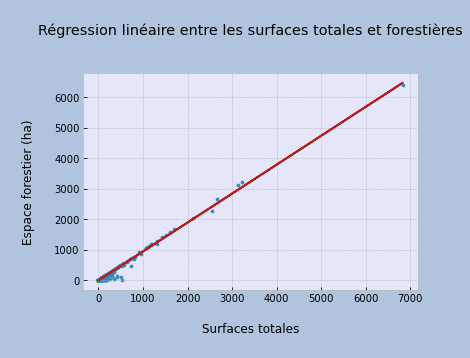

In [190]:
# graphe du modèle + observations
plt.scatter(x, y, s = 10)
plt.plot(x, y_predit, color = 'firebrick')
plt.xlabel("\nSurfaces totales\n")
plt.ylabel("\nEspace forestier (ha)\n")
plt.title("\nRégression linéaire entre les surfaces totales et forestières\n\n")
plt.show()

In [191]:
# phase d'évaluation
rmse = mean_squared_error(y, y_predit)
r2 = r2_score(y, y_predit)

In [192]:
# les valeurs caractéristiques du modèle
print("Pente du modèle: ", float(model.coef_))
print("Ordonnée à l'origine: ", float(model.intercept_))
print("Racine de l'erreur quadratique moyenne: ", rmse)
print('R² = ', r2)

Pente du modèle:  0.9474162569568897
Ordonnée à l'origine:  -0.14402433725376973
Racine de l'erreur quadratique moyenne:  33.18351806709502
R² =  0.9882669246670807


Le modèle de régression linéaire explique plus de 98% des observations.

In [193]:
# calcul du coefficient de Pearson
print('Coeff. de Pearson =', pearsonr(bdd.surf_brulee, bdd.surf_foret)[0])
print('P-value =', pearsonr(bdd.surf_brulee, bdd.surf_foret)[1])

Coeff. de Pearson = 0.9941161525028552
P-value = 0.0


Le coefficient de Pearson est très proche de 1. La p-value est infiniment proche de 0 => Nous en concluons mathématiquement à l'existence d'une relation linéaire entre les surfaces générales et les forêts.  
=> Nous pouvons écarter une des variables des analyses et choisissons de conserver les aires totales.

In [194]:
bdd.drop('surf_foret', axis=1, inplace=True)

#### [**3.2 ACP**](#table-des-matières)  
  
Les variables sont réparties en 3 profils. Nous avons celui concernant les incendies, la partie des caractéristiques géologiques et les données météo.  
=> La quantité de variables à traiter est importante donc nous appliquons une ACP afin de réduire de façon cohérente et optimale les colonnes.  
  
##### [**3.2.1 Définition des fonctions "ACP"**](#table-des-matières)

In [195]:
# fonction pour projection sur un plan factoriel avec % d'inertie
def display_factorial_plane(X_projected, n_comp, pca, axis_ranks, labels = None, alpha = 1, illustrative_var = None):
    for d1, d2 in axis_ranks:
        if d2 < n_comp:

            # initialisation de la figure
            fig = plt.figure(figsize = (7,6))

            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha = alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha = alpha, label = value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:, [d1, d2]]):
                    plt.text(x, y - .5, labels[i],
                              fontsize = '15', ha = 'center', va = 'center') 

            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1, d2]])) * 1.1
            plt.xlim([-boundary, boundary])
            plt.ylim([-boundary, boundary])

            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-100, 100], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1+1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2+1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nProjection des individus sur F{} et F{}\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [196]:
# fonction pour présenter le cercle des corrélations
def display_circles(pcs, n_comp, pca, axis_ranks, labels = None, label_rotation = 0, lims = None):
    for d1, d2 in axis_ranks: # on affiche les 3 premiers plans fatoriels => 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize = (7,6))

            # détermination des limites du graphique
            if lims is not None:
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30:
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else:
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30:
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles = 'xy', scale_units = 'xy', scale = 1, color = "grey")
            else:
                lines = [[[0,0], [x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes = ax, alpha = .1, color = 'black'))

            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]]. T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax:
                        plt.text(x, y, labels[i], fontsize = '14', ha = 'center', va = 'center', rotation = label_rotation, color = "blue", alpha = 0.5)

            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor = 'none', edgecolor = 'b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)

            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color = 'grey', ls = '--')
            plt.plot([0, 0], [-1, 1], color = 'grey', ls = '--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)\n'.format(d1 + 1, round(100 * pca.explained_variance_ratio_[d1], 1)))
            plt.ylabel('\nF{} ({}%)'.format(d2 + 1, round(100 * pca.explained_variance_ratio_[d2], 1)))

            plt.title("\nCercle des corrélations sur F{} et F{}\n\n".format(d1 + 1, d2 + 1))
            plt.show(block = False)

In [197]:
# fonction pour représenter l'éboulis des valeurs propres
def display_scree_plot(pca) :
    scree = pca.explained_variance_ratio_ * 100
    plt.bar(np.arange(len(scree)) + 1, scree)
    plt.plot(
        np.arange(len(scree)) + 1,
        scree.cumsum(),
        c = "darkred",
        marker='o'
    )
    plt.xlabel("Rang de l'axe d'inertie\n")
    plt.ylabel("\n% d'inertie")
    plt.title("\nEboulis des valeurs propres\n\n")
    plt.show(block = False)

##### [**3.2.2 Eboulis des valeurs propres**](#table-des-matières)

In [198]:
bdd.head(1)

,code_insee,annee,compteur,id_inc,dep,date,surf_brulee,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
0,01148,2006,1,2,01,2006-02-27 13:56:00,1.0,0.0,0.0,0.0,6.2,51.0,0.0,0.0,0.0


In [199]:
# préparation des données
data = bdd.iloc[:,-9:].copy()
data_var = data.columns
data_ind = list(zip(bdd.id_inc, bdd.date))

x = data.values

In [200]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

In [201]:
# choix du nombre de composantes principales
n_comp_km = min(data.shape[0] + 1, data.shape[1])

In [202]:
# calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp_km).fit(x_scaled)
x_projected = pca.transform(x_scaled)

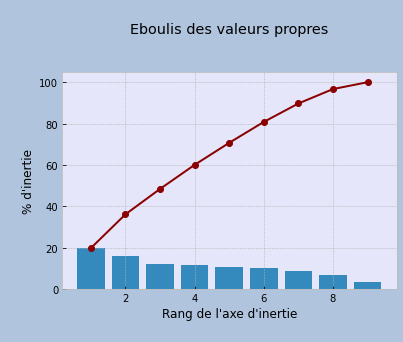

In [203]:
# représentation de l'éboulis des valeurs propres
display_scree_plot(pca)

Les composantes 3 à 6 captent sensiblement la même proportion d'inertie. Si les informations fournies par les projections et les plans factorielles  sur les premières composantes ne sont suffisantes, nous pourrons nous permettre de pousser l'analyse jusqu'à la sixième.

##### [**3.2.3 Cercle des corrélations et plan factoriel**](#table-des-matières)

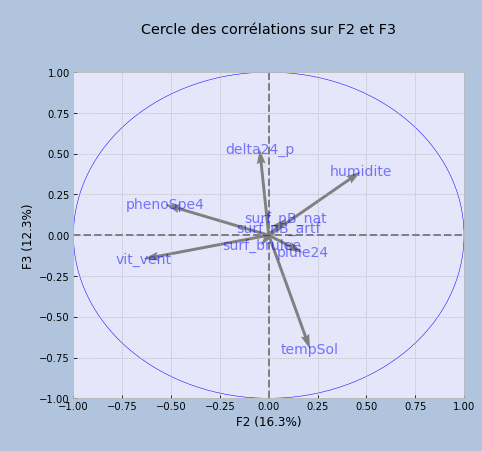

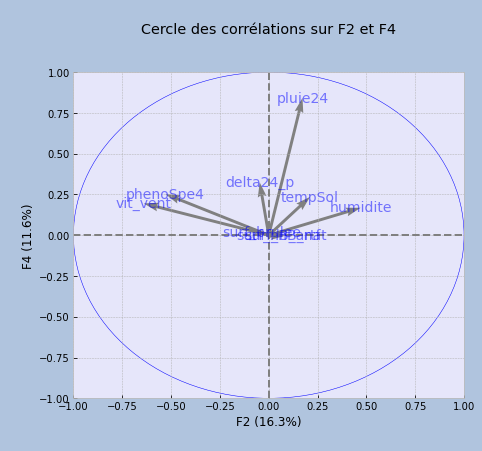

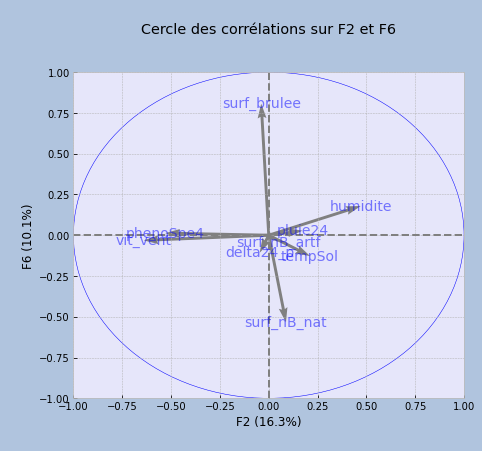

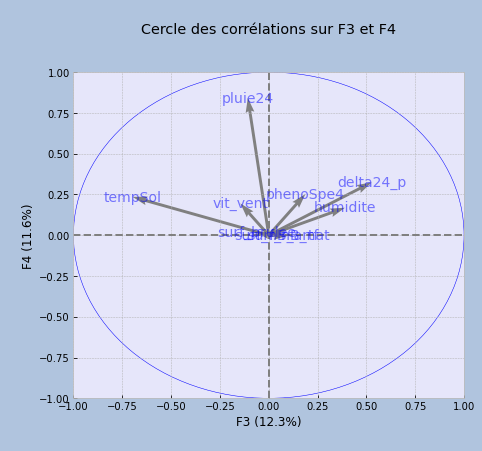

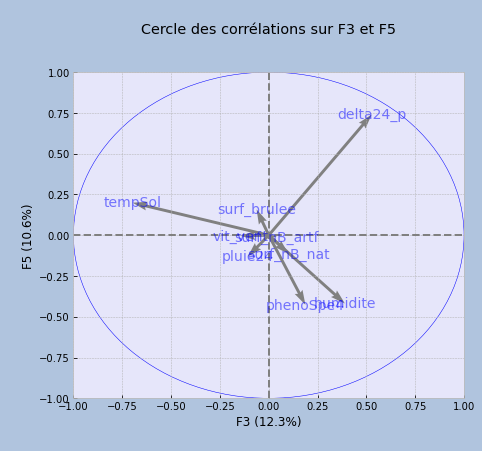

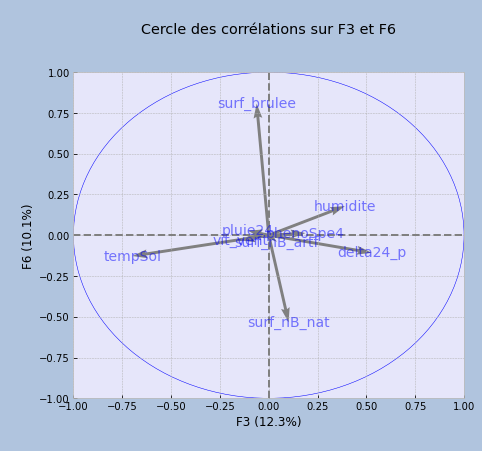

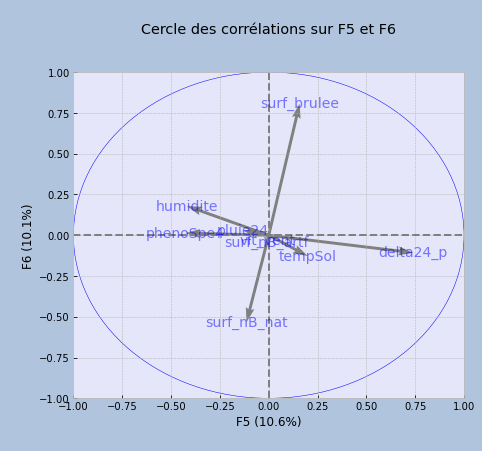

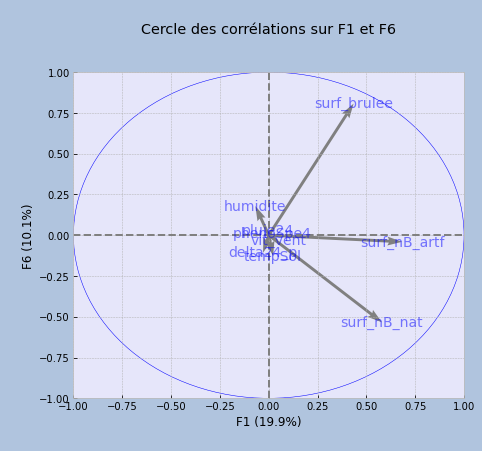

In [204]:
# extraction des données
pcs = pca.components_

# cercle des corrélation
display_circles(pcs,6, pca, [(1,2),(1,3),(1,5),(2,3),(2,4),(2,5),(4,5),(0,5)], labels=data.columns, label_rotation=0, lims=None)

**Nomenclature:** '//' = corrélé et 'a//' = anti-corrélé.  
  
o F2/F3:  
- F2 = a// (vent + phénospé) et // humidité;  
- F3 = a// température au sol et // pression;  
- angle (humidité,température) = 90° + bonne projection => variables indépendantes;  
o F2/F4:  
- F2 = a// (vent + phénomène);  
- F4 = // pluie;  
- (vent + phénomène) et pluie = indépendantes;  
o F2/F6:  
- F2 = a// (vent + phéno) et // humidité;  
- F6 = // surface brûlée et a// surface naturelle;  
- vent + phéno = indépendantes de surf_brulee;  
o F3/F4:  
- F3 = a// tempSol et // pression;  
- F4 = // pluie;  
- angle (tempSol,pluie) ~ 90 => degré d'indépendance élevée;  
o F3/F5:  
- F3 = a// tempSol et // pression;  
- F5 = // pression et a// humidité;  
- pression + température = indépendantes;  
o F3/F6:  
- F3 = a// tempSol et // pression;  
- F6 = a// surface naturelle et // surface brûlée;  
o F5/F6:  
- F5 = a// humidité et // pression;  
- F6 = a// surface naturelle et // surface brûlée;  
- pression + surface brûlées = indépendantes.  
  
=>  
- F6 est à surveiller car est en corrélation (positive ou négative) avec les variables de surfaces;
- F2 et F3 également car représentent les évènements météorologiques suceptibles de déclencher un incendie ou de favoriser sa propagation.

##### [**3.2.4 Contribution et analyse**](#table-des-matières)

In [205]:
# extraction des inerties expliquées par chaque CP
inertie_cp = pca.explained_variance_
inertie_cp

array([1.79105222, 1.46756473, 1.10380383, 1.04710934, 0.95757216,
       0.90824294, 0.80067655, 0.62627896, 0.29792251])

Les 5e et 6e composantes étant sensiblement significatives par rapport aux 3e et 4, nous décidons de les inclure dans la liste des variables synthétiques utilisées.

In [206]:
# expression des CP en fonction des variables
acp_variables = pd.DataFrame(pca.components_, columns=data.columns, index=["f"+str(i+1) for i in range(9)])

In [207]:
# extraction des données pour les 6 premières CP
acp_var = acp_variables[:6].copy()
acp_var.insert(0, 'inertie', inertie_cp[:6])
acp_var

,inertie,surf_brulee,surf_nB_nat,surf_nB_artf,delta24_p,vit_vent,humidite,tempSol,pluie24,phenoSpe4
f1,1.791052,0.434381,0.579564,0.683074,-0.029185,0.048840,-0.068456,0.022381,-0.006506,0.019039
f2,1.467565,-0.038618,0.088132,0.050194,-0.046424,-0.640003,0.470497,0.211352,0.172803,-0.529684
f3,1.103804,-0.062151,0.101676,0.041827,0.526809,-0.145362,0.389862,-0.697577,-0.107236,0.187848
f4,1.047109,0.016543,-0.001777,0.001039,0.324219,0.194963,0.168291,0.235195,0.842089,0.252666
f5,0.957572,0.158097,-0.113970,-0.009807,0.739816,-0.003621,-0.418646,0.199393,-0.131240,-0.427005
f6,0.908243,0.807039,-0.534154,-0.040336,-0.107488,-0.031568,0.178738,-0.127678,0.027824,0.012923


- F1 diférencie les types de surfaces;  
- F2 est en relation avec la vitesse du vent, l'humidité et les phénomènes spé.;  
- F3 serait presque une sorte de variable fantôme tant les projections montrent très peu voire aucun individus en corrélation avec la pression et la température au sol;  
- F4 représente des évènements météo. pontuels avec la pluie et les phénénomènes spéciaux;  
- F5 est corrélée à la pression, l'humidité et les phnéoSpé;  
- F6 = surfaces brûlées toute catégorie confondue.

In [208]:
# expression des individus en fonction des CP
acp_ind = pd.DataFrame(x_projected, columns=["f" + str(i+1) for i in range(n_comp_km)], index=data_ind)

In [209]:
# expression des individus en fonction des 6 premières CP
bdd_acp = acp_ind.iloc[:, :6].copy()

In [210]:
# changement de format des index
bdd_acp[['id_inc','date']] = bdd_acp.index.tolist()
bdd_acp.set_index(['id_inc','date'], inplace=True)

In [211]:
# extraction des inerties de chaque CP
inertie_cp = pca.explained_variance_

In [212]:
# qualité de représentation par CP
rep_f1 = acp_ind.f1/inertie_cp[0]
rep_f2 = acp_ind.f2/inertie_cp[1]
rep_f3 = acp_ind.f3/inertie_cp[2]
rep_f4 = acp_ind.f4/inertie_cp[3]
rep_f5 = acp_ind.f5/inertie_cp[4]
rep_f6 = acp_ind.f6/inertie_cp[5]

In [213]:
# df des représentations qualitatives des 6 premières composantes
quality_repr = pd.DataFrame(zip(rep_f1,rep_f2,rep_f3,rep_f4,rep_f5,rep_f6), index=data_ind)

#### [**3.3 Similarités incendiaires**](#table-des-matières)  
    
Nous commençons par comparer les clusters de deux méthodes de classification: la CAH et le K Means puis nous procédons à des tests de différentiation afin d'être sûrs de pouvoir exploiter les clusters sans interférence.  
Dans cette partie, nous utilisons la version ACP de la base de travail, Bdd_acp..

##### [**3.3.1 Clustering**](#table-des-matières)  
  
##### [**3.3.1a Méthode CAH**](#table-des-matières)

In [214]:
# préparation des données pour le clustering de Bdd_acp
x = bdd_acp.values
id_incendie = bdd_acp.index

In [215]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

In [216]:
# clustering hiérarchique
z = linkage(x_scaled, 'ward')

In [217]:
# affichage du dendrogramme
'''plt.figure(figsize=(15, 30))
plt.title('\nClustering CAH des incendies\n\n')
plt.xlabel('\nDistance\n\n')
plt.ylabel('\nIncendie\n\n')
dendrogram(
    z,
    labels=id_incendie,
    color_threshold=110,
    orientation='left'
)
plt.show()'''

"plt.figure(figsize=(15, 30))\nplt.title('\nClustering CAH des incendies\n\n')\nplt.xlabel('\nDistance\n\n')\nplt.ylabel('\nIncendie\n\n')\ndendrogram(\n    z,\n    labels=id_incendie,\n    color_threshold=110,\n    orientation='left'\n)\nplt.show()"

In [218]:
# enregistrement des clusters selon le découpage en 6 groupes
cluster_cah = fcluster(z, 6, criterion='maxclust')

In [219]:
# trie des index(individus) selon les appartenances aux clusters
cluster_cah_ind = np.argsort(cluster_cah)

In [220]:
# création d'un df dictionnaire des incendies et leur numéro de clusters
groupage_cah = pd.DataFrame(bdd_acp.index[cluster_cah_ind], cluster_cah[cluster_cah_ind])

In [221]:
# colonne renommée et utilisation des index clusters comme variables
cluster_cah = groupage_cah.reset_index()
cluster_cah.rename(columns={'index':'cluster_cah'}, inplace=True)

In [222]:
# séparation des tuples en deux colonnes
cluster_cah[['id_inc','date']] = cluster_cah.pop(0).tolist()

In [223]:
# injection des clusters dans le df Bdd_acp
bdd_acp = bdd_acp.join(cluster_cah.set_index(['id_inc','date']))

##### [**3.3.1b Méthode K Means**](#table-des-matières)

In [224]:
# clustering des données avec k-means
km = KMeans(n_clusters = 6)
km.fit(x_scaled)

KMeans(n_clusters=6)

In [225]:
# index de clusters pour chaque individu
cluster_km = km.labels_

In [226]:
# tri des clusters k-meanniens
cluster_idx_km = np.argsort(cluster_km)

In [227]:
# création d'un df de correspondance incendie/cluster_km
groupage_km = pd.DataFrame(bdd_acp.index[cluster_idx_km], cluster_km[cluster_idx_km])

In [228]:
# renommage de colonne et conversion des index "clusters_km" en colonne
cluster_km = groupage_km.reset_index()
cluster_km.rename(columns={'index':'cluster_km'}, inplace=True)

In [229]:
# réorganisation de Cluster_km pour intro dans Bdd_acp
cluster_km[['id_inc','date']] = cluster_km.pop(0).tolist()

In [230]:
# injection des clusters dans le df Bdd_acp
bdd_acp = bdd_acp.join(cluster_km.set_index(['id_inc','date']))

In [231]:
# aperçu des effectifs des clusters pour vérifier les outliers, aka cluster mono-pays
bdd_acp.cluster_km.value_counts()

0    17416
2    14395
5     7405
3     1065
4       30
1        6
Name: cluster_km, dtype: int64

In [232]:
# aperçu des effectifs des clusters pour vérifier les outliers, aka cluster mono-pays
bdd_acp.cluster_cah.value_counts()

3    26630
1    12607
5      966
6       77
2       33
4        4
Name: cluster_cah, dtype: int64

In [233]:
# affection des clusters dans le df principal
bdd = bdd.join(bdd_acp[['cluster_cah','cluster_km']], on=['id_inc','date'])

##### [**3.3.2 Test de différenciation**](#table-des-matières)  
  
Avant d'exploiter les clusters obtenus, nous devons nous assurer qu'ils soient statistiquement différent.  
Nous commençons par cherche une variable dont la distribution suit une loi normale puis l'utilisons pour tester les groupes.  
  
##### [**3.3.2.a Variable témoin**](#table-des-matières)  
   
**Environnement:**  
Les effectifs de mesures comportent plus de 50 unités et des variables sont qualitatifs => nous choisissons le test non-paramétré de Kolmogorov-Smirnov.  
  
**Les hypothèse:**  
- H0: la distribution de la variable testée suit une loi normale;  
- Ha: la loi de la distribution en question ne suit pas une loi normale.  
  
**Environnement du test:**  
- Statistique de test: Kolmogorov Dn; 
- Risque alpha = 1%;   
- Nous posons n, l'effectif de la variable à tester: n = len(Bdd) >> 100 => valeur critique ~ c/√n = 1.224/√40233 ~  0.006 ;  
- Condition de rejet: Dn > c/√n <=> Dn > 0.006

In [234]:
# initialisation du dataframe Test_K-S
test_ks = pd.DataFrame(index=bdd_acp.columns[:6], columns=['statistique_d', 'p_value'])

##### [**3.3.2 Test de différenciation**](#table-des-matières)  
  
Les étapes:  
o préparation des données;  
o analyse de l'environnement dans lequel se déroule la comparaison;  
o choix du test en fonction de l'environnement;  
o construction des hypothèses et de la région critique;  
o test;  
o conclusion.  
  
o Etape 1/6: préparation des clusters A et B

In [235]:
cluster_a = bdd[bdd.cluster_cah==1].cluster_cah
cluster_b = bdd[bdd.cluster_cah==5].cluster_cah

o Etape 4/6 : construction des hypothèses  et de la région critique
  
On note s_i, la variance de l'échantillon i.  
- H0: s_a² = s_b²  
- H1: s_a² != s_b²  
  
- Statistique de test: analogue à la statistique de test F, admise  
- Risque d'erreur alpha = 5%  
 
- Condition de rejet de H0: p-value du test de Levene < alpha    
- Condition de validation de H0: p-value > alpha  
  
o Etape 5/6 : test de Levene

In [236]:
#levene(cluster_a, cluster_b, center = 'median')

o Etape 6/6 : conclusion
=> p-value > alpha  
=> H0 ne peut être rejetée  
  
Les variances ne montrant de différence significative, nous procédons à un test T afin de comparer les moyennes des deux clusters.  
  
- H0: moy_a = moy_b  
- H1: moy_a <> moy_b, moy_i, la moyenne de l'échantillon i  
  
- Condition de validation de H0: la p-value engendrée par le test T est supérieur au risque d'erreur alpha de 5%.

In [237]:
'''ttest(
    cluster_a, cluster_b,
    paired = False,
    confidence = 0.95,
    correction = False
)'''

'ttest(\n    cluster_a, cluster_b,\n    paired = False,\n    confidence = 0.95,\n    correction = False\n)'

=> p-value, 6.11 x 10^(-14) du test T est nettement inférieur à alpha, 5%;  
=> H0 est rejetée : l'écart est suffisament important pour que les moyennes soient considérées n'est pas validée comme étant inhomogène;  
=> l'hypothèse de nullité principale selon laquelle les clusters ne sont pas différenciés est rejetée  
=> le clustering effectué est significatif et ses données peuvent être exploitée pour l'étude de marché avec une marge d'erreur de 5%

##### [**3.4 Caractéristiques des incendies**](#table-des-matières)  
  
##### [**3.4.1 Profil des clusters**](#table-des-matières)  
  
Par la suite, nous utiliserons les clusters réalisés avec la méthode CAH.

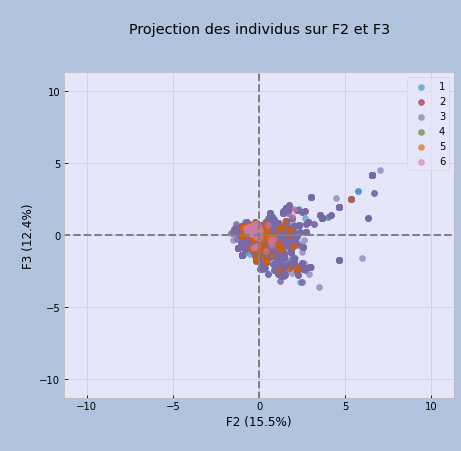

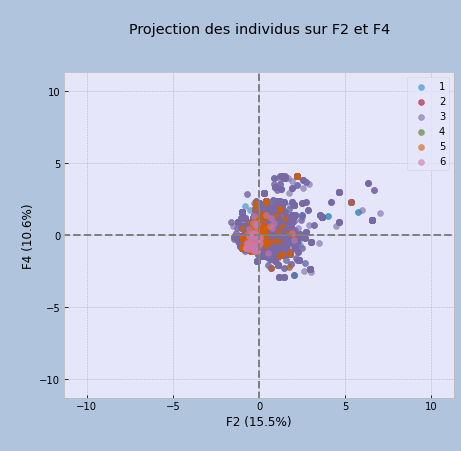

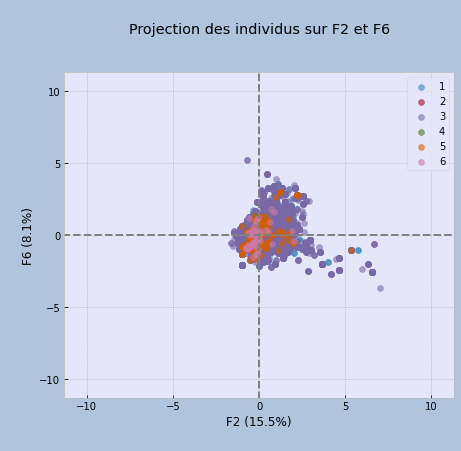

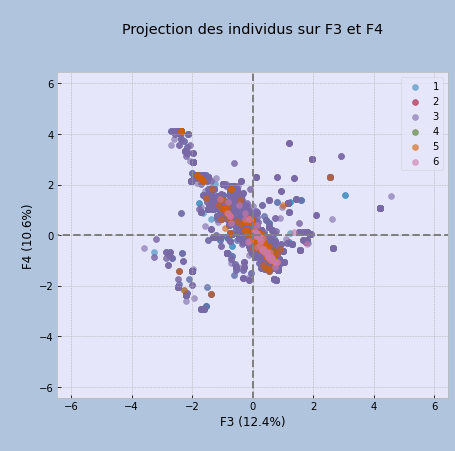

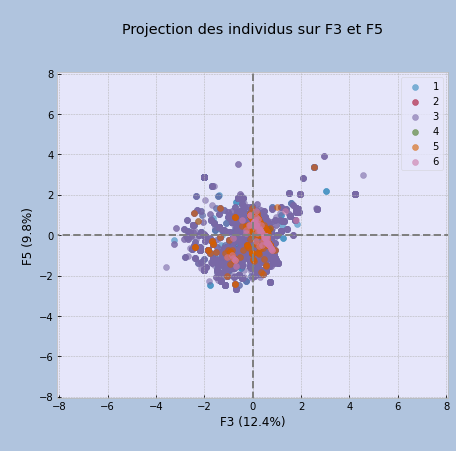

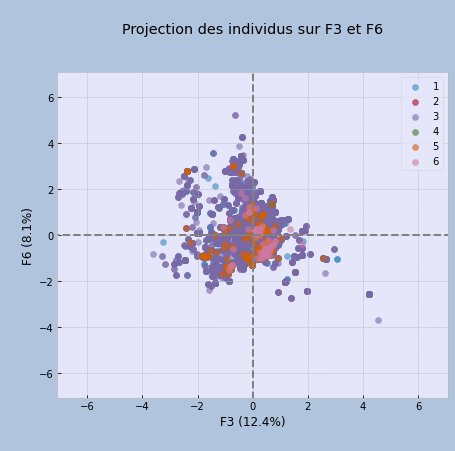

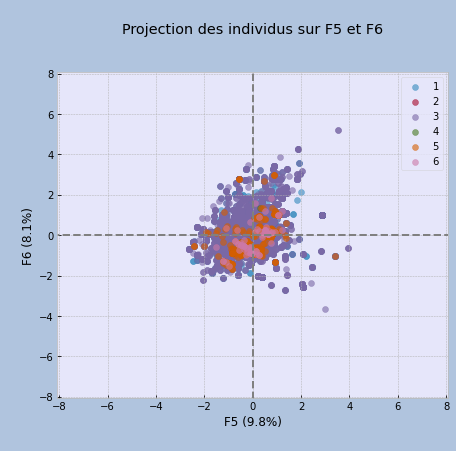

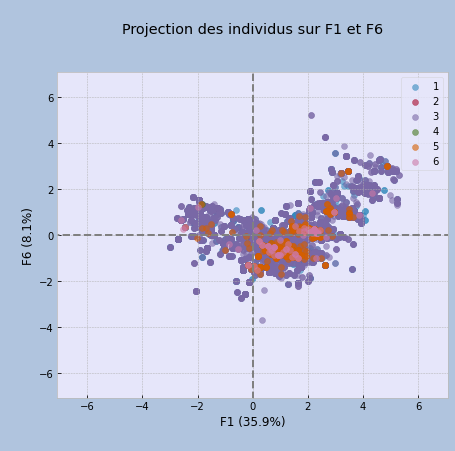

In [263]:
# projection des individus dans les plans factoriels
display_factorial_plane(x_projected, 6, pca, [(1,2),(1,3),(1,5),(2,3),(2,4),(2,5),(4,5),(0,5)], None, .6, bdd.cluster_cah)

**Rappel de la nomeclature:**  
- corrélation: "//";  
- anti-corrélation: "a//".  
  
**Par plan:**  
  
o F2/F3:  
- Rappel: caractérisé par les variables température au sol, humidité, vitesse du vent et phénomènes spéciaux;  
- C2 // vent  
- C4 // humidité  
- C5 // phénoSpé  
- C6 // (humidité + tempSol)  
  
o F3/F4:  
- Rappel: pluie, tempSol, pression;  
- C6 // pluie  
  
o F3/F5:  
- Rappel: pression, tempSol, humidite, phénoSpé;  
- C2 // (pression + tempSol)  
- C3 attiré par pression  
- C4 // humidité  
- C5 attiré par phénoSpé  
  
o F3/F6:  
- Rappel: surf_brulee, tempSol, surf_nB_nat;  
- C2 // surf_brulee  
- C3 influencé par surf naturelle  
- C4 // surf naturelle  
  
o F5/F6:  
- Rappel: surf_brulee, pression, surf naturelle non boisée;  
- C2 // surf_brulee  
- C3 influencé par les surfaces naturelles  
- C4 // surf_nB_nat  
  
o F1/F6:  
- Rappel: surf_brulee, surf. naturelle et surface artificielle;  
- C2 // surf_brulee  
- C3 = divisé en 2 sous-groupes: 1 // surf. nat et 2 // surf. artificielle  
  
**Par cluster: les caractéristiques**  
- C1: aucune corrélation n'a pu être mise en évidence pour ce cluster  
- C2: vent, pression, tempSol et, surf_brulee  
- C3: pression + distinctio entre les deux types de surfaces non boisées  
- C4: humidité, surf_nB_nat  
- C5: phénoSpé
- C6: pluie, humidité, tempSol.  
  
**Interprétation:**  
- Le cluster 2 regroupe les incendies les plus dévastateurs dont l'ampleur est certainement due aux conditions climatiques extrêmes et instables;  
- Les clusters 3 et 4 rassemblent les brasiers concernant des terrains non boisés et donc de surperficies restreintes, peut être en partie grâce à la situation météorologique;  
- L'origine des flammes dans les évènements du cinquième cluster sont d'origine naturelle;  
- Le sixième cluster réunit les alertes caractérisées par la situation météorologique.

In [268]:
# part du cluster 5 sur la totalité
fx_nat = len(bdd[bdd.cluster_cah==5]) * 100 / len(bdd)
print("Les feux d'origine naturelle représentent {} % des incendies.".format(round(fx_nat,2)))

Les feux d'origine naturelle représentent 2.4 % des incendies.


In [239]:
clustering = bdd.groupby(['annee','cluster_cah']).sum()
clustering.reset_index('cluster_cah', inplace=True)

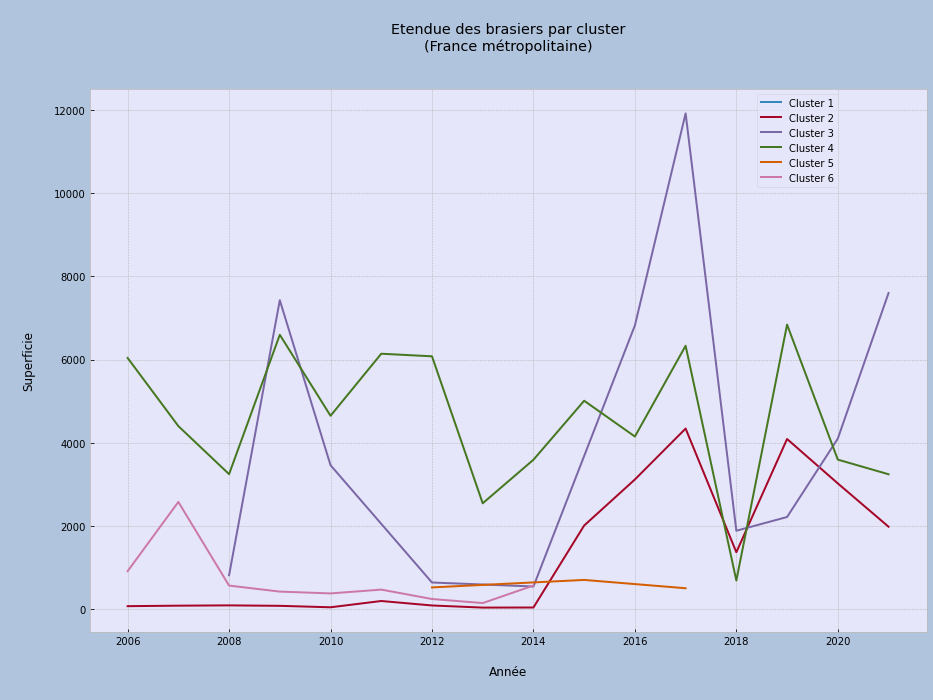

In [240]:
# taille des incendies par cluster et par an
fig,ax = plt.subplots(figsize=(15,10))

for i in range(6):
    clustering[clustering.cluster_cah==i].surf_brulee.plot(ax=ax, label='Cluster {}'.format(i+1))

ax.set_title('\nEtendue des brasiers par cluster\n(France métropolitaine)\n\n')
ax.set_xlabel('\nAnnée\n')
ax.set_ylabel("\nSuperficie\n")
ax.legend(bbox_to_anchor=(0.9,1), frameon=True)

plt.show()

In [241]:
# rappel des effectifs par cluster
bdd.groupby('cluster_cah').size()

cluster_cah
1    12607
2       33
3    26630
4        4
5      966
6       77
dtype: int64

En confrontant l'évolution des surfaces concernées par les différents clusters et le comportement général des incendies au cours des 16 dernières années, nous remarquons que les braisiers du troisième profil sont ceux qui générent les phases alpha des cycles incendiers. Quant au cluster 4, concernant uniquement les petites surfaces, il "nourrit" les nombres des alertes de la phase beta.  
La représentation du profil 1, caractérisé par aucune variable en particulier, ne ressort pas sur ce graphique. Nous le traçons à part.

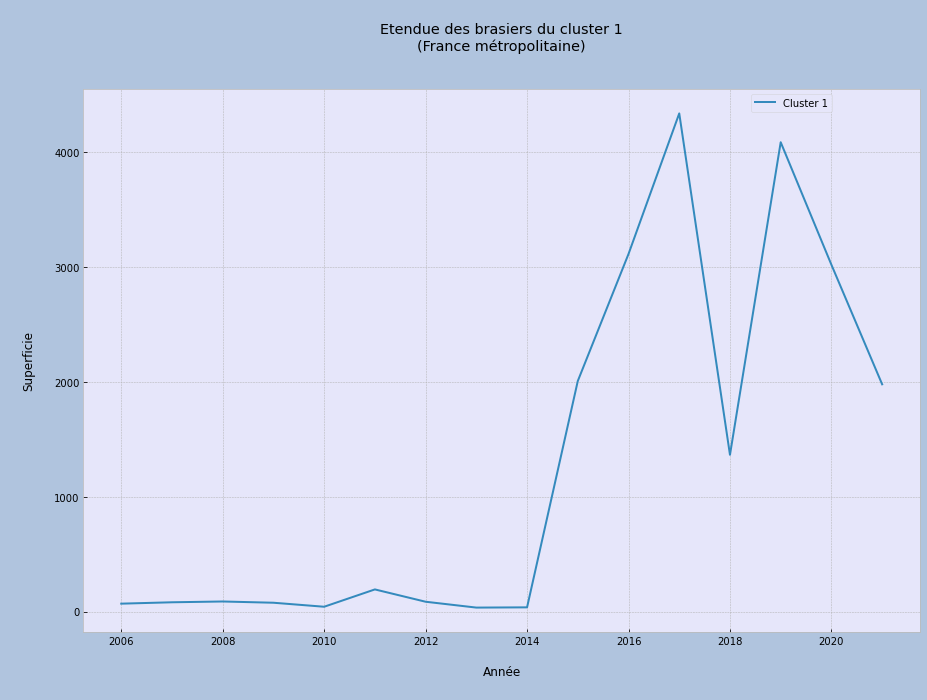

In [242]:
# taille des incendies du cluster 1
fig,ax = plt.subplots(figsize=(15,10))

clustering[clustering.cluster_cah==1].surf_brulee.plot(ax=ax, label='Cluster 1')

ax.set_title('\nEtendue des brasiers du cluster 1\n(France métropolitaine)\n\n')
ax.set_xlabel('\nAnnée\n')
ax.set_ylabel("\nSuperficie\n")
ax.legend(bbox_to_anchor=(0.9,1), frameon=True)

plt.show()

Les individus de ce groupe apparaissent comme des incencies de "nouvelle génération". Puisqu'une aucune corrélation n'a été mise en évidence, on ne peut que supposer un lien avec l'évolution des conditions météorologiques dûes au réchauffement climatique.

##### [**3.4.2 Caractéristiques géologiques**](#table-des-matières)  
  
Nous venons de regrouper les brasiers en fonction des circonstances de leur naissance et de leurs similitudes physiques. Maintenant, nous nous concentrons sur leur milieu de propagation en étudiant les caractéristiqes géologiques de chaque cluster.  
  
Nous commençons par affecter les clusters à la base de travail contenant les données environnementales Bdd_ign. Il nous reste ensuite à confronter ses résultats avec les observations précédemment établies.

In [243]:
# Bdd_ign + Bdd: jointure à gauche [clef = 'id_inc','date]
bdd_ign = bdd_ign.merge(bdd[['id_inc','date','cluster_cah']])
bdd_ign.head(1)

,code_insee,annee,compteur,id_inc,date,surf_brulee,surf_foret,surf_nB_nat,surf_nB_artf,delta24_p,...,essence,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau,cluster_cah
0,01148,2006,1,2,2006-02-27 13:56:00,1.0,1.0,0.0,0.0,0.0,...,03,310.0,7,5,1,9,6,7,115.0,3


In [244]:
# préparation des données
data = bdd_ign.iloc[:,-9:-1].copy()
data_var = data.columns[:8]
data_ind = bdd_ign.cluster_cah

x = data.iloc[:,:8].values

In [245]:
# centrage et réduction
std_scale = preprocessing.StandardScaler().fit(x)
x_scaled = std_scale.transform(x)

In [246]:
# choix du nombre de composantes principales
n_comp_km = min(data.shape[0] + 1, data.shape[1])

In [247]:
# calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp_km).fit(x_scaled)
x_projected = pca.transform(x_scaled)

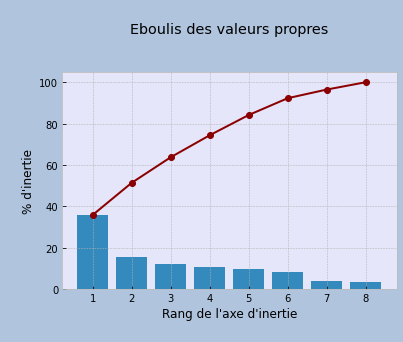

In [248]:
# représentation de l'éboulis des valeurs propres
display_scree_plot(pca)

In [249]:
# extraction des inerties expliquées par chaque CP
inertie_cp = pca.explained_variance_
inertie_cp

array([2.87185724, 1.2414138 , 0.98820434, 0.85017251, 0.78200796,
       0.64957179, 0.33370467, 0.28309592])

La quatrième composante n'est pas de très bonne qualité mais nous ne l'excluons pas en cas de besoin.

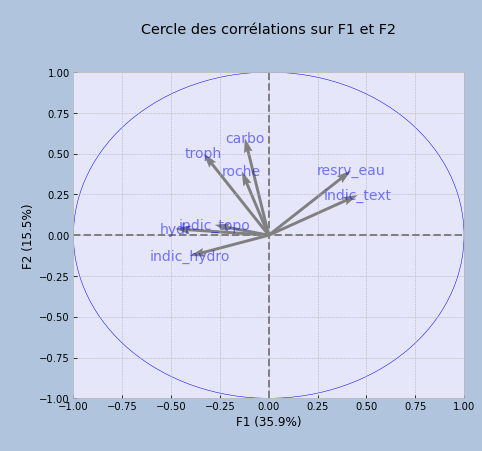

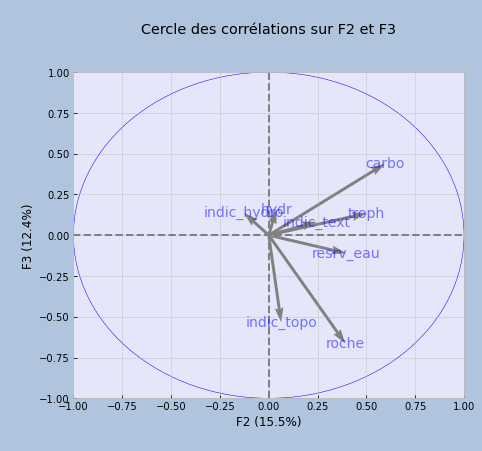

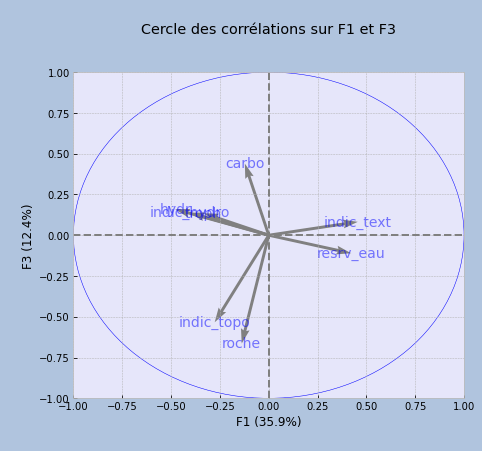

In [250]:
# extraction des données
pcs = pca.components_

# cercle des corrélation
display_circles(pcs,3, pca, [(0,1),(1,2),(0,2)], labels=data.columns, label_rotation=0, lims=None)

In [251]:
# expression des CP en fonction des variables
acp_variables = pd.DataFrame(pca.components_, columns=data.columns, index=["f"+str(i+1) for i in range(8)])

In [252]:
# extraction des données pour les 3 premières CP
acp_var = acp_variables[:3]
acp_var

,roche,carbo,indic_hydro,indic_topo,indic_text,hydr,troph,resrv_eau
f1,-0.138451,-0.122458,-0.403871,-0.276796,0.455740,-0.479231,-0.333398,0.421417
f2,0.392269,0.595987,-0.127343,0.063414,0.246200,0.039111,0.501322,0.396509
f3,-0.664048,0.439073,0.137718,-0.533751,0.082092,0.159113,0.134721,-0.110423


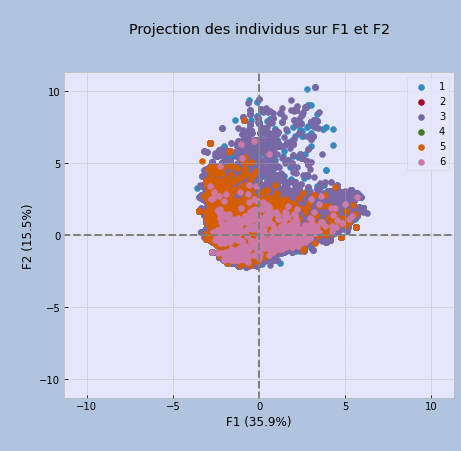

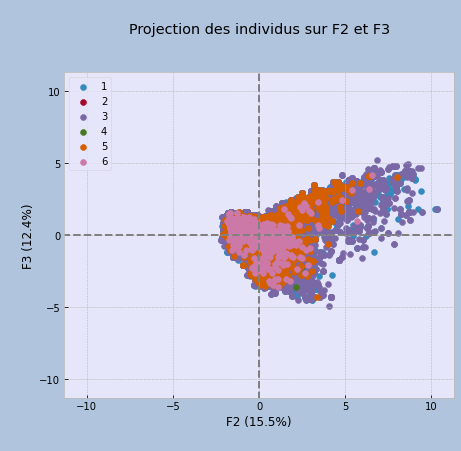

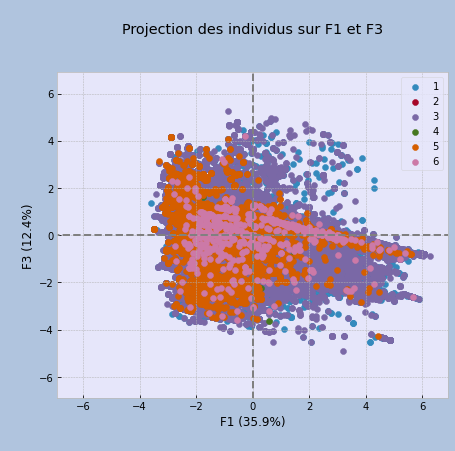

In [253]:
# projection des individus dans les plans factoriels
display_factorial_plane(x_projected, 3, pca, [(0,1),(1,2),(0,2)], None, 1, data_ind)

**Nomenclature:**  
- corrélation: "//"  
- anti-corrélation: "a//"  
- influencé: "~//"  
- en opposition: "-//"
  
**Observations:**  
  
o F1/F2:  
- C1 = //carbo et ~//indic_txt  
- C3 = //carbo + //indic_text  
- C5 = //indix_text + //(troph+carbo)  
- C6 = C5  
  
o F2/F3:  
- Ensemble = //carbo  
  
o F1/F3:  
- C1 = //indic_topo + hydro et //(roche+indix_text)    
- C3 = C1  
- C5 = //indic_topo et ~//indic_text et //hydro  
- C6 = //indic_topo et ~//indic-text et ~//hydro  
  
o F3/F4:  
- C1 = //indic_topo  
- C3 = C1  
- C4 = //indic_topo et ~//roche  
- C5 = ~//indic_topo et ~//roche  
- C6 = C5  
  
o F1/F4:  
- C1 = //(indic_topo+indic_txt)  
- C3 = C1  
- C5 = C6 = ~//indic_topo  
  
o F2/F4:  
- Ensemble visible = //carbo  
  
**Profil des clusters:**  
  
- C1: indic_topo + indic_text + roche + carbo + hydro  
- C2: carbo  
- C3: indic_topo + indic_text + roche + hydro + roche  
- C4: indic_topo + roche + carbo  
- C5: indic_text + idic_topo + hydro + roche  
- C6: indic_text + idic_topo + hydro + roche

**Résumé:**  
- Nous avons clusterisé les incendies;  
- Nous savons quels sont les paramètres caractéristiques de chaque cluster;  
  
=> Il nous reste à récupérer les valeurs dominantes de ces paramètres pour pouvoir qualifier le profil des clusters du point de vue du métier. Npus procédons à la main.

In [254]:
# création d'un df par cluster
cluster_c1 = bdd_ign[bdd_ign.cluster_cah==1].iloc[:,-9:-1]
cluster_c2 = bdd_ign[bdd_ign.cluster_cah==2].iloc[:,-9:-1]
cluster_c3 = bdd_ign[bdd_ign.cluster_cah==3].iloc[:,-9:-1]
cluster_c4 = bdd_ign[bdd_ign.cluster_cah==4].iloc[:,-9:-1]
cluster_c5 = bdd_ign[bdd_ign.cluster_cah==5].iloc[:,-9:-1]
cluster_c6 = bdd_ign[bdd_ign.cluster_cah==6].iloc[:,-9:-1]

**o C1:** indic_topo + indic_text + roche + carbo + hydro

In [255]:
for variable in cluster_c1.columns:
    print(cluster_c1[variable].value_counts())

233.0    19654
230.0    13785
110.0    13398
310.0    12115
330.0     7046
         ...  
900.0        2
140.0        2
153.0        2
999.0        1
712.0        1
Name: roche, Length: 63, dtype: int64
0    79461
2     1508
1     1409
3     1135
4      641
5      273
6      128
7       61
8       43
9        2
Name: carbo, dtype: int64
5    67170
4    12341
3     2603
1     1280
2     1238
0       29
Name: indic_hydro, dtype: int64
1    41672
3    17120
4    11265
2     6241
5     4005
6     3641
0      717
Name: indic_topo, dtype: int64
7     26386
3     21208
2     14275
6     11854
9      5475
8      2458
1      1636
5       623
4       592
10       91
0        63
Name: indic_text, dtype: int64
9    19203
8    18625
4    10729
3    10190
5     9064
7     7459
6     6991
2     2246
1       91
0       63
Name: hydr, dtype: int64
3     21213
2     15771
4     10800
10    10792
9      7743
8      4919
5      4346
7      3276
6      2833
1      2806
11       99
0        63
Name: troph, 

**o C2:** carbo

In [256]:
for variable in cluster_c2.columns:
    print(cluster_c2[variable].value_counts())

110.0    75
233.0    72
310.0    39
330.0    13
810.0     9
212.0     8
403.0     6
811.0     6
800.0     4
812.0     4
237.0     3
230.0     3
313.0     2
314.0     2
210.0     1
332.0     1
822.0     1
213.0     1
331.0     1
338.0     1
211.0     1
Name: roche, dtype: int64
0    235
2      7
1      5
3      3
4      2
5      1
Name: carbo, dtype: int64
5    227
4     23
3      2
1      1
Name: indic_hydro, dtype: int64
1    104
3     56
4     46
2     22
5     15
6      8
0      2
Name: indic_topo, dtype: int64
7    77
3    76
2    59
6    18
9    12
1     9
4     1
8     1
Name: indic_text, dtype: int64
9    104
8     77
7     21
4     20
3     17
5      7
6      5
2      2
Name: hydr, dtype: int64
3     82
4     51
2     37
10    26
9     21
5     12
7      9
8      9
6      5
1      1
Name: troph, dtype: int64
63.0     61
26.0      8
21.0      7
24.0      7
0.0       6
         ..
87.0      1
95.0      1
53.0      1
61.0      1
122.0     1
Name: resrv_eau, Length: 76, dtype: int6

**o C3:** indic_topo + indic_text + roche + hydro + roche

In [257]:
for variable in cluster_c3.columns:
    print(cluster_c3[variable].value_counts())

233.0    54539
110.0    35986
310.0    24632
230.0    22269
330.0    14818
         ...  
999.0        4
243.0        3
242.0        2
140.0        1
153.0        1
Name: roche, Length: 64, dtype: int64
0    180302
2      3384
1      3286
3      2676
4      1546
5       683
6       300
7       203
8        63
9         7
Name: carbo, dtype: int64
5    152574
4     31173
3      4921
1      1955
2      1768
0        59
Name: indic_hydro, dtype: int64
1    95944
3    37751
4    26193
2    14533
5     8956
6     7220
0     1853
Name: indic_topo, dtype: int64
7     68123
3     48419
2     33138
6     21165
9     11082
8      4307
1      3734
5      1126
4      1069
10      177
0       110
Name: indic_text, dtype: int64
8    48595
9    45922
3    22870
4    22435
5    17992
7    16486
6    14194
2     3654
1      165
0      137
Name: hydr, dtype: int64
3     52143
2     38168
4     26736
10    22220
9     15356
8      9710
5      8987
1      6801
7      6360
6      5650
11      182
0       1

**o C4:** indic_topo + roche + carbo

In [258]:
for variable in cluster_c4.columns:
    print(cluster_c4[variable].value_counts())

810.0    3
403.0    3
110.0    2
932.0    1
310.0    1
230.0    1
Name: roche, dtype: int64
0    9
2    1
4    1
Name: carbo, dtype: int64
5    11
Name: indic_hydro, dtype: int64
3    4
2    3
4    3
6    1
Name: indic_topo, dtype: int64
3    7
6    3
2    1
Name: indic_text, dtype: int64
4    4
5    4
7    2
8    1
Name: hydr, dtype: int64
2    3
7    3
8    2
4    2
5    1
Name: troph, dtype: int64
41.0     2
140.0    1
55.0     1
61.0     1
142.0    1
64.0     1
32.0     1
37.0     1
131.0    1
36.0     1
Name: resrv_eau, dtype: int64


**o C5:** indic_text + idic_topo + hydro + roche

In [259]:
for variable in cluster_c5.columns:
    print(cluster_c5[variable].value_counts())

310.0    1450
330.0     811
811.0     366
230.0     337
110.0     307
810.0     302
403.0     232
812.0     189
233.0     154
800.0     133
212.0     124
314.0     108
407.0      69
313.0      67
116.0      65
332.0      62
338.0      53
210.0      39
600.0      32
238.0      30
101.0      28
404.0      28
237.0      26
102.0      26
236.0      18
408.0      17
232.0      17
211.0      16
331.0      15
604.0      15
930.0      12
231.0      12
938.0      10
506.0       8
143.0       8
213.0       6
333.0       6
911.0       6
312.0       3
932.0       3
234.0       3
316.0       2
500.0       2
239.0       2
334.0       2
751.0       1
410.0       1
936.0       1
339.0       1
750.0       1
939.0       1
Name: roche, dtype: int64
0    4535
2     201
1     172
3     171
4     114
5      23
7       9
8       1
6       1
Name: carbo, dtype: int64
5    4973
4     159
3      40
1      29
2      26
Name: indic_hydro, dtype: int64
1    1652
3    1479
4    1037
2     557
5     289
6     183
0 

**o C6:** indic_text + idic_topo + hydro + roche

In [260]:
for variable in cluster_c6.columns:
    print(cluster_c6[variable].value_counts())

233.0    233
110.0    149
230.0    110
310.0     50
330.0     47
810.0     23
407.0     13
408.0      9
313.0      9
403.0      7
116.0      7
236.0      6
811.0      6
238.0      5
338.0      4
500.0      3
800.0      3
332.0      3
314.0      3
234.0      2
812.0      2
600.0      2
237.0      2
212.0      2
231.0      2
232.0      2
334.0      1
932.0      1
211.0      1
101.0      1
750.0      1
210.0      1
604.0      1
312.0      1
930.0      1
751.0      1
939.0      1
Name: roche, dtype: int64
0    691
3      6
1      6
2      6
5      3
6      2
4      1
Name: carbo, dtype: int64
5    488
4    184
3     23
1     13
2      7
Name: indic_hydro, dtype: int64
1    388
3    124
4     81
2     53
5     36
6     27
0      6
Name: indic_topo, dtype: int64
7     306
3     130
2     112
6      75
9      51
8      21
1      12
5       6
4       1
10      1
Name: indic_text, dtype: int64
8    182
3    122
9    106
4    102
5     78
7     57
6     41
2     27
Name: hydr, dtype: int64
3    

##### Profil métier des clusters

C1:indic_topo + indic_text + roche + carbo + hydro
    - roche: 233, 230 et 110
    - carbo:0
    - indic topo: 1-3 = pente faible ou nulle, rayonement inférieur à 110
    - indic text : 7-3-2 = sol drainant sableux ou limoneux ou sls peu profond et très caillouteux avec peu de rétention affleurement sup à 65%
    - hydr:9-8  4-3 = sol principalemnt très secs en permanence ou à la période estivale à assèchement posibe durant les étés

C2: carbo = 0


C3-:indic_topo + indic_text + roche + hydro + roche
    - roche:233-110-310  sable non conso/granite/calcaire conso
    - indic topo:1-3-4 = pente nulle à légère, ombrage, faible rayonnement 
    - indic text:7-3-2 = sol drainant sableux ou limoneux ou sls peu profond et très caillouteux avec peu de rétention affleureument sup à 65%
    - hydr:8-9-3 sol secs parmanents ou zone humide asséchées en été

**o C4:** indic_topo + roche + carbo
    - indic topo: 3-2-4 = pente légère, ensolleiment non contraignant
    - roche 810-403 roche metamorphique/roche calc sédimentaire effervscence variable à l'acide chloridrique puvant dégagé de très forte odeur
    - carbo:11

**o C5:** indic_text + idic_topo + hydro + roche
    - roche: 310-330-811-230  calcaire conso/calcaire non conso/roche métamorpique/sable non conso
    - indic topo: 3-2-6 des pentes faiblement enseollilé ou vallée + zone de collecte d'eau
    - indic text: 3-2-6 = affleuremen rocheux compris entre 35 et 74% voire davantage , sol limon ou argile
    - hydr:9-8 = sol principalemnt très secs en permanence ou à la période estivale

**o C6:** indic_text + idic_topo + hydro + roche
    - roche: 233-110-230 sable onon consolidée/granite/roche de sillice
    - indic topo:1-2 pente faible à accentuer permettant ruisselement
    - indic text: 7-3-2 = sol drainant sableux ou limoneux ou sls peu profond et très caillouteux avec peu de rétention affleureument sup à 65%
    - hydr: 3-2 = zone humidifiée asséchante en été ou humide en permanance

##### Rappel des paramètres dominants  
  
- C1: indic_topo + indic_text + roche + carbo + hydro  
- C2: carbo  
- C3: indic_topo + indic_text + roche + hydro + roche  
- C4: indic_topo + roche + carbo  
- C5: indic_text + idic_topo + hydro + roche  
- C6: indic_text + idic_topo + hydro + roche

In [274]:
# rappel des effectifs
bdd_acp.cluster_cah.value_counts()

3    26630
1    12607
5      966
6       77
2       33
4        4
Name: cluster_cah, dtype: int64

In [281]:
cluster_moy = bdd.groupby('cluster_cah').mean()
cluster_moy[['surf_brulee']]

,surf_brulee
cluster_cah,
1,1.636137
2,1436.661109
3,2.745836
4,430.000000
5,6.481358
6,0.256413


#### [**4. Prévisions des GF**](#table-des-matières)  
  
##### [**4.1 Modélisation**](#table-des-matières)

##### [**4.2 Prévisions 2022**](#table-des-matières)

## **------------------------------------------**  
## **------------------------------------------**